In [319]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import calendar
from scipy import integrate

In [320]:
available_parkings = ['Vilanova', 'SantSadurni', 'SantBoi', 'QuatreCamins',
                      'Cerdanyola','Granollers','Martorell','Mollet',
                      'SantQuirze','PratDelLlobregat']
df_column_name=['Parking Vilanova Renfe','Parking Sant Sadurní Renfe','Parking Sant Boi de Llobregat',
              'Parking Quatre Camins','Cerdanyola Universitat Renfe','Parking Granollers Renfe',
                'Parking Martorell FGC','Parking Mollet Renfe','Parking Sant Quirze FGC',
               'Parking Prat del Ll.']
current_parking_ix=4
# problems on Weekend with 4 Cerdanyola, 
# some data is shifte in  2 SantBoi
# bad data 6 Martorell, 8 SantQuirze 
# different Filter 3 QuatreCamins,  4 Cerdanyola,
#good 0 Vilanova, 1 SantSadurni, 5 Granollers, 7 Mollet, 9 PratDelLlobregat 
current_parking = available_parkings[current_parking_ix]
current_column_name=df_column_name[current_parking_ix]
df = pd.read_csv('data/'+current_parking+"_Estable.csv", delimiter=";")
df = df.dropna()
df = df.reset_index(drop=True)
df.head(6)

DateTime Cerdanyola Universitat Renfe plazas totales
0  01/01/2020 0:00                                 68,40574036
1  01/01/2020 0:30                                 67,26972245
2  01/01/2020 1:00                                  66,7614765
3  01/01/2020 1:30                                      66,405
4  01/01/2020 2:00                                      66,405
5  01/01/2020 2:30                                      66,405

# Data processing and preliminary analysis

In [321]:
def getDayName(d):
    return calendar.day_name[d.weekday()]

df = pd.read_csv('data/'+current_parking+"_Estable.csv", delimiter=";")
df = df.dropna()
df['Date'] = df['DateTime'].apply(lambda x: x.split(' ')[0])
df['Time'] = df['DateTime'].apply(lambda x: x.split(' ')[1])
df['Free slots'] = df[current_column_name +' plazas totales'].apply(lambda x: int(x.split(',')[0]))
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
df.sort_values(by="Date")
df['Weekday'] = df.apply(lambda x: getDayName(x['Date']),axis=1)
df['Date'] = [d.date().strftime("%Y-%m-%d") for d in df['Date']]
df = df.drop(['DateTime'], axis=1)
df = df.drop([current_column_name +' plazas totales'], axis=1)

max_value = df["Free slots"].max()
min_value = df["Free slots"].min()
df['Occupancy'] = df['Free slots'].map(lambda x: max_value-x)
axis_ylim = max_value+20
axis_ylim_low = 0
print('Y lim: ' ,axis_ylim)
df.head()

Y lim:  142


Date  Time  Free slots    Weekday  Occupancy
0  2020-01-01  0:00          68  Wednesday         54
1  2020-01-01  0:30          67  Wednesday         55
2  2020-01-01  1:00          66  Wednesday         56
3  2020-01-01  1:30          66  Wednesday         56
4  2020-01-01  2:00          66  Wednesday         56

In [322]:
# GLOBAL VARIABLES THAT MUST BE FILLED ALONG THE Jup. NOTEBOOK FOR THE EXPORT
max_capacity = max_value

hist_weekday_proto = []
hist_friday_proto  = []
hist_weekend_proto = []

tn_weekday_pars = []
tn_friday_pars  = []
tn_weekend_pars = []

tn_weekday_proto = []
tn_friday_proto  = []
tn_weekend_proto = []

time = np.linspace(0,23.5,48)

In [323]:
x_date=pd.to_datetime(df['Date']+' '+df['Time'])
y_occ=df['Occupancy']

### Delete days that have not to be taken into account

In [326]:
#only optimized for Vilanova and QuatreCamins

if current_parking == "QuatreCamins":
    days_list = ['2020-01-01', '2020-01-06', '2020-01-18', '2020-02-07', '2020-02-23', '2020-03-14', '2020-03-15',
                 '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', 
                 '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', 
                 '2020-03-30', '2020-02-29', '2020-01-19']
elif current_parking == "Cerdanyola":  
    days_list = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05', '2020-01-06', '2020-01-11',
                 '2020-01-12', '2020-01-18', '2020-01-19', '2020-01-25', '2020-01-26', 
                 '2020-02-09', '2020-02-29', '2020-03-01', '2020-03-14', '2020-03-15', '2020-03-16', 
                 '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', 
                 '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', 
                 '2020-03-31']
else:
    days_list = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06', '2020-02-07', '2020-03-16', '2020-03-17', '2020-03-18', 
                 '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26', 
                 '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31']

#days_list = ['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06', '2020-02-06', '2020-02-07', '2020-02-23', '2020-02-28', 
#             '2020-03-16', '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21', '2020-03-22', '2020-03-23',
#             '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-02-29',
#             '2020-01-19']

def checkDataValidty(date):
    if date in days_list: 
        return False
    else:
        return True

In [327]:
from itertools import compress
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

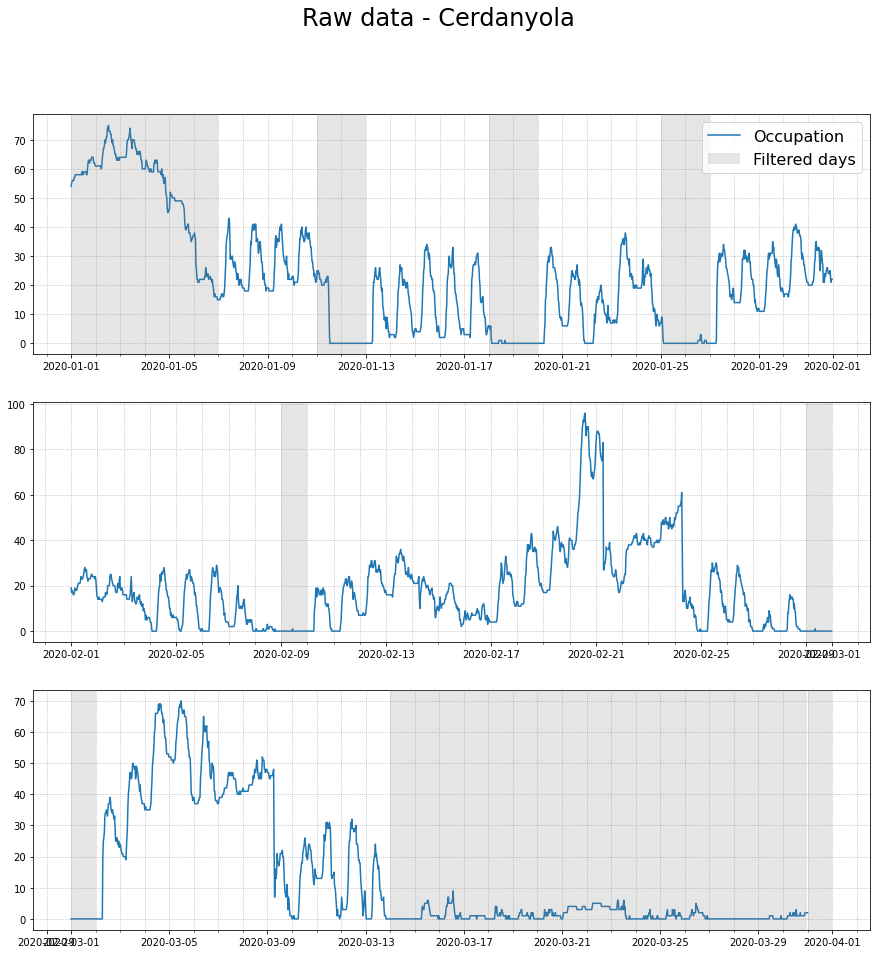

In [328]:
fig, ax = plt.subplots(3,1,figsize=(15,15))

#fig, ax = plt.subplots(1,3)

fig.suptitle('Raw data - '+current_parking, fontsize=24)
#plt.subplot(3,1,1)
ax[0].plot(x_date[0:(31*48)],y_occ[0:(31*48)], label='Occupation')
ax[0].grid(which='major',linestyle='dotted')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[0].grid(which='minor', linestyle=':')

td_days_list=pd.to_datetime(days_list)
index_dates=td_days_list<pd.to_datetime("2020-02-01")
days_list01=list(compress(days_list, index_dates))
bol_once=True
for datestr in days_list01:
    initDate= pd.to_datetime(datestr)
    finDate=pd.to_datetime(datestr +' 23:59:00')
    ax[0].axvspan(initDate,finDate, facecolor='grey', alpha=0.2, label='Filtered days', zorder=4)
    if bol_once:
        ax[0].legend(fontsize=16)
        bol_once=False
    
#plt.subplot(3,1,2)
ax[1].plot(x_date[(31*48):((31+29)*48)],y_occ[(31*48):((31+29)*48)])
ax[1].grid(which='major',linestyle='dotted')
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].grid(which='minor', linestyle=':')

index_dates=(td_days_list<pd.to_datetime("2020-03-01")) & (td_days_list>pd.to_datetime("2020-01-31"))
days_list02=list(compress(days_list, index_dates))
for datestr in days_list02:
    initDate= pd.to_datetime(datestr)
    finDate=pd.to_datetime(datestr +' 23:59:00')
    ax[1].axvspan(initDate,finDate, facecolor='grey', alpha=0.2, label='Filtered days', zorder=4)
    

#plt.subplot(3,1,3)
ax[2].plot(x_date[((31+29)*48):((31+29+31)*48)],y_occ[((31+29)*48):((31+29+31)*48)]);
ax[2].grid(which='major',linestyle='dotted')
ax[2].xaxis.set_minor_locator(AutoMinorLocator(1))
ax[2].grid(which='minor', linestyle=':')
           
index_dates=(td_days_list<pd.to_datetime("2020-04-01")) & (td_days_list>pd.to_datetime("2020-02-29"))
days_list03=list(compress(days_list, index_dates))
for datestr in days_list03:
    initDate= pd.to_datetime(datestr)
    finDate=pd.to_datetime(datestr +' 23:59:00')
    ax[2].axvspan(initDate,finDate, facecolor='grey', alpha=0.2, label='Filtered days', zorder=4)
    

In [329]:
df['Stable Data'] = df['Date'].apply(lambda x: checkDataValidty(x))
df_holidays = df[df['Stable Data'] == False]
df = df[df["Stable Data"] == True]

## Mean free slots by weekday

In [330]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_days = df.groupby([df['Weekday']], as_index=False).mean()

# REORDER BY DAY
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
key = df_days['Weekday'].map(mapping)
df_days = df_days.iloc[key.argsort()]
df_days.reset_index(inplace=True, drop=True) 

#df_bla = df.groupby('Weekday').agg({'score': ['mean', 'std']})

In [331]:
# cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# # esta bien esto?
# df_days = df.groupby('Weekday').agg({'Occupancy': ['mean', 'std']})
# # df_days = df.groupby('Weekday').agg({'Occupancy': ['mean', 'std']})

# # REORDER BY DAY
# days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
# mapping = {day: i for i, day in enumerate(days)}
# df_days.reset_index(inplace=True, drop=False) 
# key = df_days['Weekday'].map(mapping)
# df_days = df_days.iloc[key.argsort()]
# df_days.reset_index(inplace=True, drop=True) 
# means = df_days['Occupancy']['mean']
# stds = df_days['Occupancy']['std']
# df

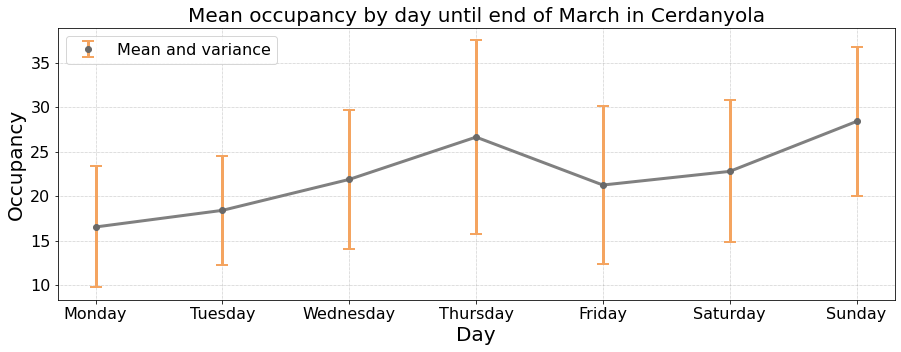

In [332]:
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_days_ = df.groupby('Weekday').agg({'Occupancy': ['mean', 'std']})
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
mapping = {day: i for i, day in enumerate(days)}
df_days_.reset_index(inplace=True, drop=False) 
key = df_days_['Weekday'].map(mapping)
df_days_ = df_days_.iloc[key.argsort()]
df_days_.reset_index(inplace=True, drop=True) 
means = df_days_['Occupancy']['mean']
stds = df_days_['Occupancy']['std']

x = df_days_['Weekday']
y = means
err = stds
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x,y, color='grey',  linewidth=3)
plt.errorbar(x, y,
            xerr=None,
            yerr=err/2, fmt='o',color='dimgray',label="Mean and variance",
             ecolor='sandybrown', elinewidth=3, capsize=6, capthick=2)
plt.title('Mean occupancy by day until end of March in '+current_parking, fontsize=20)
plt.xlabel('Day', fontsize = 20)
plt.ylabel('Occupancy', fontsize = 20)
plt.legend(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
df = df.reset_index(drop = True)

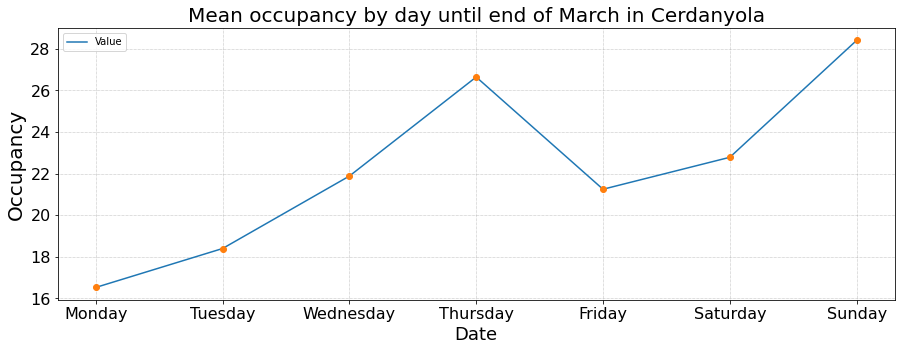

In [333]:
x = df_days['Weekday']
y = df_days['Occupancy']
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(x,y, label='Value')
plt.plot(x,y,'o')
plt.title('Mean occupancy by day until end of March in '+current_parking, fontsize=20)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Occupancy', fontsize = 20)
plt.legend()
# changing the fontsize of yticks
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
# plt.xticks(fonstize=14)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
df = df.reset_index(drop = True)

In [334]:
df_days['Occupancy']

0    16.530093
1    18.400000
2    21.881250
3    26.639583
4    21.247917
5    22.783333
6    28.401042
Name: Occupancy, dtype: float64

## Compute the mean for different days

In [335]:
def toAbsHour(hour):
    beginning = [int(s) for s in hour.split(':')]
    absol_hour = (beginning[0] + beginning[1]/60 )
    return absol_hour

df_byhour = df
df_byhour['ABS_Hour'] = df_byhour['Time'].apply(lambda x: toAbsHour(x) )

df_hours = df_byhour
df_hours['hour'] = df_hours['ABS_Hour'].map(lambda x: (int(2*x))/2)


# Normalization

In [336]:
def Area_by_date(date):
    df_day = df[(df['Date'] == date)]
    Profile = df_day['Occupancy'].values
    Area = integrate.simps(Profile)
    return Area

df_hours['Area'] = df_hours['Date'].apply(lambda x: Area_by_date(x))

def df_normalization(occ, area):
    if area == 0:
        return 'error'
    return occ/area

df_hours['Normalized_occupancy'] = df_hours.apply(lambda x: df_normalization(x.Occupancy, x.Area), axis=1)

#df_hours = df_hours.drop(['Occupancy'], axis=1)
#df_hours['Occupancy'] = df_hours['Normalized_occupancy'].apply(lambda x: x)
df_mean_slots = df_hours.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()

In [337]:
mean_occupancy = df_mean_slots['Occupancy']

In [338]:
Monday_occ = mean_occupancy['Monday']
Tuesday_occ = mean_occupancy['Tuesday']
Wednesday_occ = mean_occupancy['Wednesday']
Thursday_occ = mean_occupancy['Thursday']
Friday_occ = mean_occupancy['Friday']
Saturday_occ = mean_occupancy['Saturday']
Sunday_occ = mean_occupancy['Sunday']

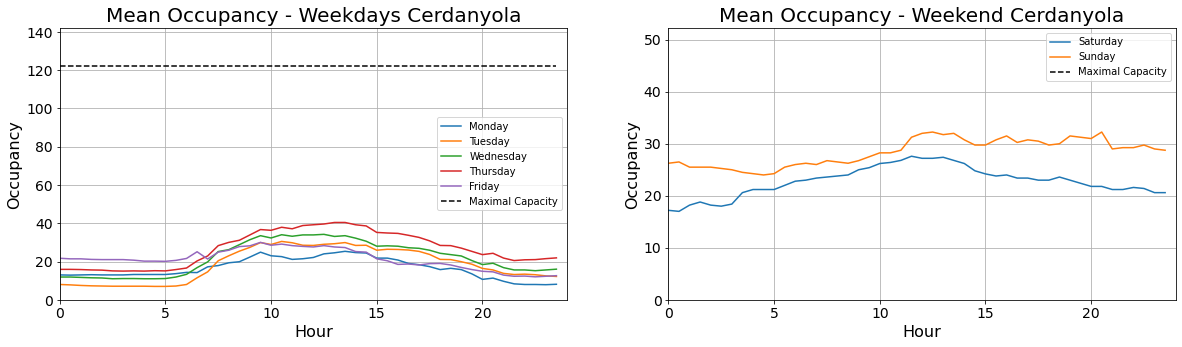

In [339]:
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
maximal_line = np.zeros(48)+max_value;
time=np.linspace(0,23.5,48);


plt.plot(Monday_occ,label='Monday')
plt.plot(Tuesday_occ,label='Tuesday')
plt.plot(Wednesday_occ,label='Wednesday')
plt.plot(Thursday_occ, label='Thursday')
plt.plot(Friday_occ,label='Friday')
plt.plot(time, maximal_line,'--',color='black',label='Maximal Capacity')

plt.title('Mean Occupancy - Weekdays '+current_parking, fontsize=20)
plt.xlabel('Hour', fontsize=16); plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(labelsize=14)
plt.axis([0, 24, 0, axis_ylim])
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(Saturday_occ,label='Saturday')
plt.plot(Sunday_occ,label='Sunday')
plt.plot(time, maximal_line,'--',color='black',label='Maximal Capacity')

axis_ylim_we=max(max(Saturday_occ),max(Sunday_occ))+20

plt.title('Mean Occupancy - Weekend '+current_parking, fontsize=20)
plt.xlabel('Hour', fontsize=16); plt.ylabel('Occupancy', fontsize=16)
plt.tick_params(labelsize=14)
plt.axis([0, 24, 0, axis_ylim_we])
plt.legend()
plt.grid()

## Variance computation

In [340]:
def mean_day(Weekday,date):
    df = df_hours[(df_hours['Weekday'] == Weekday)]
    df_day = df[(df['Date'] == date)]
    df_day_mean = df_day.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Weekday]
    return Day

def generate_mean_variance(accumulated_date, accumulated_free_slots):
    aux_dict = {};
    for ii in np.arange(len(accumulated_date)):
        free_slots = list(accumulated_free_slots[ii].iat)
        hour = list(accumulated_free_slots[ii].index)
        for jj in np.arange(len(free_slots)):
            current_hour = hour[jj]
            if current_hour not in aux_dict:
                aux_dict[current_hour] = []
            aux_dict[current_hour].append(free_slots[jj])
    return aux_dict

def compute_mean_variance(aux_dict):
    domain = np.linspace(0,23,47)
    var_vec = []; mean_vec = []; hour_vec=[];
    for ii in domain:
        if ii in aux_dict:
            var_vec.append(np.var(list(aux_dict[ii])))
            mean_vec.append(np.mean(list(aux_dict[ii])))
            hour_vec.append(ii)
    return var_vec, mean_vec, hour_vec

### Visualize days

48
48
48
48
48
48
48
48
48


Text(0.5, 0, 'Time [h], 0.5 step ')

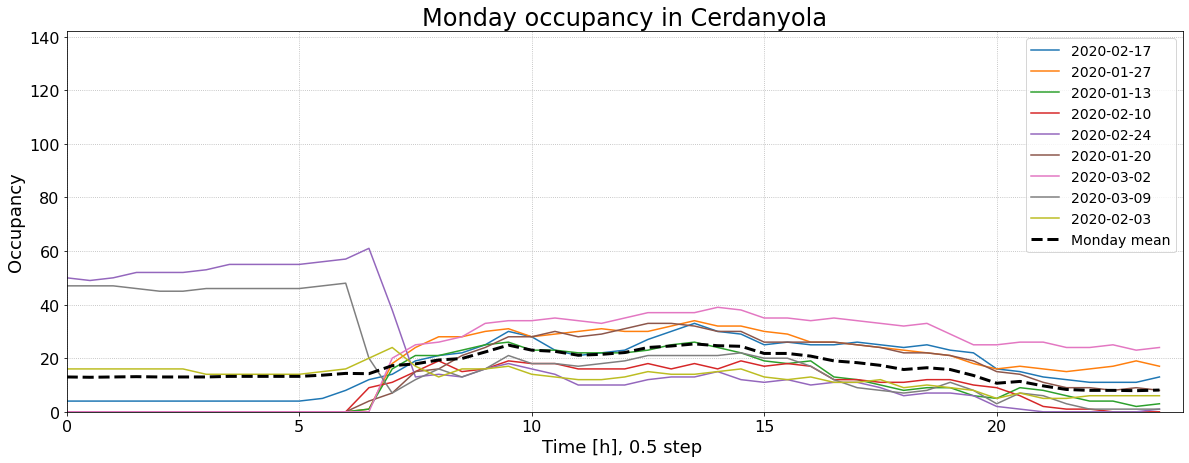

In [341]:
Weekday = 'Monday'
Day_df = df_hours[(df_hours['Weekday'] == Weekday)]
dates = Day_df['Date']
dates_options = set(dates[:][:])
dates_options = list(dates_options)
lockdown_dates=[];
#lockdown_dates.append('06/01/2020')
# lockdown_dates.append('16/01/2020')
# lockdown_dates.append('30/01/2020')
# lockdown_dates.append('23/01/2020')

fig = plt.figure(figsize = (20,7))
accumulated_free_slots=[];
accumulated_date=[];

for ii in np.arange(len(dates_options)):
    day = dates_options[ii]
    Day = mean_day(Weekday,day)
    aux_vec=np.zeros(24)
    Day_list = list(Day)
    accumulated_date.append(day)
    accumulated_free_slots.append(Day)
    plt.plot(Day,label=day)
    print(len(Day.values))
    
label_tag = Weekday + ' mean'
plt.title('Monday occupancy in '+current_parking, fontsize=24)
plt.plot(Monday_occ,'--', color='black', label = label_tag, linewidth=3)
plt.axis([0, 24, axis_ylim_low, axis_ylim])
plt.grid(linestyle='dotted')
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Occupancy', fontsize=18)
plt.xlabel('Time [h], 0.5 step ', fontsize=18)

# PREDICTION 

### Prepare the data for the prediction

In [342]:
def classify_2_proto(x):
    weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    if x in weekday_list:
        return 'Weekday'
    else:
        return 'Weekend'


def classify_3_proto(x):
    weekday_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday']
    weekend_list = ['Saturday', 'Sunday']
    if x in weekday_list:
        return 'Weekday'
    elif x in weekend_list:
        return 'Weekend'
    else:
        return 'Friday'
    

# 1 week data = 336 rows (48*7) WE ASUME WE HAVE COMPLETE DATA WITHOUT GAPS BETWEEN HOURS, AND DATA FROM 0.0 TO 23.5
# @from_end: if the testing data is retrieved from the last part of the df or from th beginning. By default, from the end
# @limit_date: if we want to get the train from specific date instead of by number of weeks

def split_data(df, n_test_weeks, limit_date = None, from_end=True): 
    if(limit_date != None):
        init_test = df[df['Date']==limit_date].index[0];
        end_test = df.shape[0]
        test_domain = range(init_test, end_test)
        test_domain = list(test_domain)

    else:
        if(from_end == True):
            end_test = df.shape[0]
            week_domain = n_test_weeks*336
            init_test = end_test-week_domain
            test_domain = range(init_test, end_test)
            test_domain = list(test_domain)
            
        elif(from_end == False):
            week_domain = n_test_weeks*336
            init_test = 0
            end_test = week_domain
            test_domain = range(0,week_domain)
            test_domain = list(test_domain)
            
    test_df = df[init_test:end_test]
    training_df = df.drop(test_domain)
    return training_df, test_df

In [343]:
df_byhour['MonthNumber']= df_byhour['Date'].apply(lambda x: x.split('-')[1])
df_prediction_mean = df_byhour.groupby(by=['Date','hour','MonthNumber','Weekday'], axis = 0, as_index=False).mean()
df_prediction_mean['Profile_2'] = df_prediction_mean['Weekday'].apply(lambda x: classify_2_proto(x))
df_prediction_mean['Profile_3'] = df_prediction_mean['Weekday'].apply(lambda x: classify_3_proto(x))

### Split data in Training/Testing df

In [344]:
number_of_testing_weeks = 3
df_training, df_testing = split_data(df_prediction_mean, number_of_testing_weeks)
df_train_data = df_training
df_train_data.head(5)
df_testing.head()

Date  hour MonthNumber   Weekday  Free slots  Occupancy  \
1776  2020-02-20   0.0          02  Thursday          81         41   
1777  2020-02-20   0.5          02  Thursday          82         40   
1778  2020-02-20   1.0          02  Thursday          82         40   
1779  2020-02-20   1.5          02  Thursday          82         40   
1780  2020-02-20   2.0          02  Thursday          82         40   

      Stable Data  ABS_Hour         Area  Normalized_occupancy Profile_2  \
1776         True       0.0  3085.083333              0.013290   Weekday   
1777         True       0.5  3085.083333              0.012966   Weekday   
1778         True       1.0  3085.083333              0.012966   Weekday   
1779         True       1.5  3085.083333              0.012966   Weekday   
1780         True       2.0  3085.083333              0.012966   Weekday   

     Profile_3  
1776   Weekday  
1777   Weekday  
1778   Weekday  
1779   Weekday  
1780   Weekday

## PREDICTION BY MEAN

In [345]:
def mean_day_profile(Profile, df_aux):
    df = df_aux[(df_aux['Profile_2'] == Profile)]
    df_day_mean = df.groupby(by=['Profile_2','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Profile]
    return Day

def mean_of_day(Weekday,date):
    df = df_hours[(df_hours['Weekday'] == Weekday)]
    df_day = df[(df['Date'] == date)]
    df_day_mean = df_day.groupby(by=['Weekday','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    Day = mean_free_slots[Weekday]
    return Day

# Get all days of the type (Monday, Tuesday...) and return the mean of them
def get_days(dayname, df_):
    data_temp = df_[df_['Weekday'] == dayname] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days

# Get unique dates of the type (Monday, Tuesday...) 
def get_dates(dayname, df_):
    data_temp = df_[df_['Weekday'] == dayname] 
    dates = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Occupancy'][i:i+48]
        t_date = data_temp.iloc[i]['Date']
        if len(day) == 48:
            dates.append(t_date)
        
    return dates

def get_days_of_protos(proto_name, df_):
    data_temp = df_[df_['Profile_3'] == proto_name] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days


In [346]:
# ------------------------ NEW TESTING DATA -----------------------------
# these variables are arrays of days
testing_mondays    = get_days("Monday", df_testing)
testing_tuesdays   = get_days("Tuesday", df_testing)
testing_wednesdays = get_days("Wednesday", df_testing)
testing_thursdays  = get_days("Thursday", df_testing)
testing_fridays    = get_days("Friday", df_testing)
testing_saturdays  = get_days("Saturday", df_testing)
testing_sundays    = get_days("Sunday", df_testing)


testing_mondays_dates    = get_dates("Monday", df_testing)
testing_tuesdays_dates   = get_dates("Tuesday", df_testing)
testing_wednesdays_dates = get_dates("Wednesday", df_testing)
testing_thursdays_dates  = get_dates("Thursday", df_testing)
testing_fridays_dates    = get_dates("Friday", df_testing)
testing_saturdays_dates  = get_dates("Saturday", df_testing)
testing_sundays_dates    = get_dates("Sunday", df_testing)

In [347]:
# ------------------------ TESTING DATA -----------------------------

real_monday = mean_of_day('Monday','2020-02-24')
real_tuesday = mean_of_day('Tuesday','2020-02-11')
real_wednesday = mean_of_day('Wednesday','2020-02-26')
real_thursday = mean_of_day('Thursday','2020-02-27')

################## Bad/None data on last Feb week ############################
real_friday = mean_of_day('Friday','2020-03-06') 
real_saturday= mean_of_day('Saturday','2020-03-07')
real_sunday = mean_of_day('Sunday','2020-03-08')

### 3 Prototypes: Weekday, Friday & Weekend

In [348]:
def mean_day_profile_3(Profile, df_aux):
    df = df_aux[(df_aux['Profile_3'] == Profile)]
    df_day_mean = df.groupby(by=['Profile_3','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    profile = mean_free_slots[Profile]
    return profile

In [349]:
# Obtain the 3 protoypes. IMPORTANT! We assume all the data in df is valid, robust and correct
def train_statistical_model(df): 
    df_day_mean = df.groupby(by=['Profile_3','hour'], axis = 0, group_keys=True).mean()
    mean_free_slots = df_day_mean['Occupancy']
    return mean_free_slots['Weekday'], mean_free_slots['Friday'], mean_free_slots['Weekend'] 

weekdays = ['Monday', 'Thursday', 'Wednesday', 'Tuesday']
weekend= ['Saturday', 'Sunday']

# Simply return the proper prototype
def predict_full_day_statistical(day): 
    if day in weekdays: 
        return hist_weekday_proto
    elif day in weekend: 
        return hist_weekend_proto
    else:
        return hist_friday_proto


def get_proto_by_day(day_name):
    if day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday']:
        return 
    return


def get_scale_factor(current_data, proto):
    index = len(current_data)
    proto_val = proto[index-1]
    last_hour_val = current_data[-1]
    scaling = last_hour_val/proto_val
    return scaling 


def predict_real_time(day, current_hour, current_value, max_capacity, pred_type):
    if pred_type == "Stat":
        proto = get_proto_by_day(day) #Get from statistical prototypes
    else: 
        scale_factor = get_scale_factor(current_value, proto_value)
        prediction = np.array(proto)*scale_factor
    return prediction


In [350]:
hist_weekday_proto, hist_friday_proto, hist_weekend_proto = train_statistical_model(df_train_data)
prediction = predict_full_day_statistical('Monday')

#### Plotting  prototypes

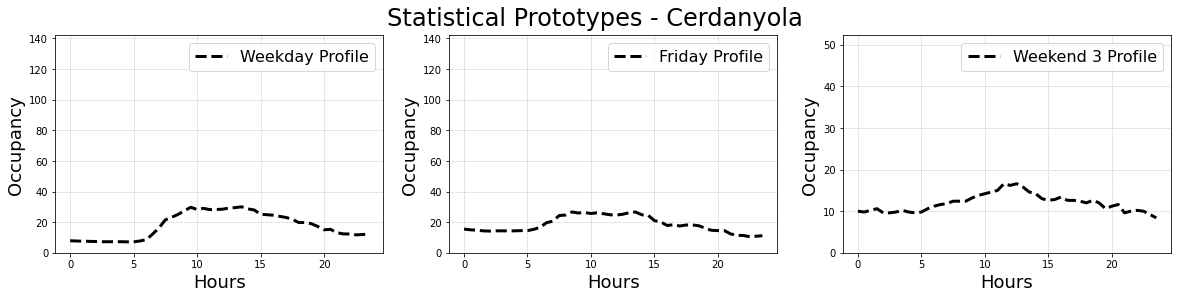

In [351]:
Weekday_proto = mean_day_profile_3('Weekday',df_train_data)
Weekend_proto = mean_day_profile_3('Weekend',df_train_data)
df_fri = df_train_data.drop(df_train_data[df_train_data['Date'] == '2020-02-07' ].index)
Friday_proto = mean_day_profile_3('Friday',df_fri)

fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Statistical Prototypes - '+current_parking, fontsize=24)

ax[0].plot(hist_weekday_proto, linestyle='--', label='Weekday Profile', color='k', linewidth=3)
# ax[0].plot(real_monday.index.tolist(), real_monday.values.tolist(), label='Monday')
# ax[0].plot(real_tuesday.index.tolist(), real_tuesday.values.tolist(), label='Tuesday')
# ax[0].plot(real_wednesday.index.tolist(), real_wednesday.values.tolist(), label='Wednesday')
# ax[0].plot(real_thursday.index.tolist(), real_thursday.values.tolist(), label='Thursday')
ax[0].set_ylim([0,axis_ylim])
# ax[0].set_title("Weekday prototype")
ax[0].set_ylabel('Occupancy', fontsize=18)
ax[0].set_xlabel('Hours', fontsize=18)
ax[0].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[0].legend(fontsize=16)

ax[1].plot(hist_friday_proto, linestyle='--', label='Friday Profile', color='k', linewidth=3)
# ax[1].plot(real_friday.index.tolist(), real_friday.values.tolist(), label='Friday')
ax[1].set_ylim([0,axis_ylim])
# ax[1].set_title("Friday prototype")
ax[1].set_ylabel('Occupancy', fontsize=18)
ax[1].set_xlabel('Hours', fontsize=18)
ax[1].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[1].legend(fontsize=16)

ax[2].plot(hist_weekend_proto, linestyle='--', label='Weekend 3 Profile', color='k', linewidth=3)
# ax[2].plot(real_saturday.index.tolist(), real_saturday.values.tolist(), label='Saturday')
# ax[2].plot(real_sunday.index.tolist(), real_sunday.values.tolist(), label='Sunday')
ax[2].set_ylim([0,axis_ylim_we])
# ax[2].set_title("Weekend prototype")
ax[2].set_ylabel('Occupancy', fontsize=18)
ax[2].set_xlabel('Hours', fontsize=18)
ax[2].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[2].legend(fontsize=16);
# fig.tight_layout(pad=3.0)


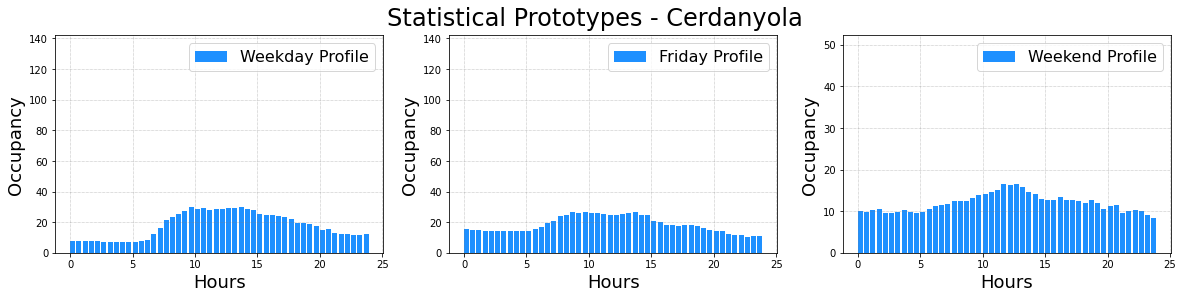

In [352]:
Weekday_proto = mean_day_profile_3('Weekday',df_train_data)
Weekend_proto = mean_day_profile_3('Weekend',df_train_data)
df_fri = df_train_data.drop(df_train_data[df_train_data['Date'] == '2020-02-07' ].index)
Friday_proto = mean_day_profile_3('Friday',df_fri)

fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Statistical Prototypes - '+current_parking, fontsize=24)

ax[0].bar(hist_weekday_proto.index +0.2,hist_weekday_proto.values, width=0.4, label='Weekday Profile', color='dodgerblue', linewidth=3)
ax[0].set_ylim([0,axis_ylim])
# ax[0].set_title("Weekday prototype")
ax[0].set_ylabel('Occupancy', fontsize=18)
ax[0].set_xlabel('Hours', fontsize=18)
ax[0].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[0].legend(fontsize=16)

ax[1].bar(hist_friday_proto.index +0.2,hist_friday_proto.values, width=0.4, label='Friday Profile', color='dodgerblue', linewidth=3)
ax[1].set_ylim([0,axis_ylim])
# ax[1].set_title("Friday prototype")
ax[1].set_ylabel('Occupancy', fontsize=18)
ax[1].set_xlabel('Hours', fontsize=18)
ax[1].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[1].legend(fontsize=16)

ax[2].bar(hist_weekend_proto.index +0.2, hist_weekend_proto.values, width=0.4, label='Weekend Profile', color='dodgerblue', linewidth=3)

ax[2].set_ylim([0,axis_ylim_we])
# ax[2].set_title("Weekend prototype")
ax[2].set_ylabel('Occupancy', fontsize=18)
ax[2].set_xlabel('Hours', fontsize=18)
ax[2].grid(linestyle='dotted', linewidth='0.5', color='grey')
ax[2].legend(fontsize=16);
# fig.tight_layout(pad=3.0)


In [353]:
def subplot_training(fig, ax, xx, yy, proto_data, test_days, day, proto_name): 
    ax[xx,yy].plot(time, proto_data, linewidth=2.5, linestyle='dashed', label= proto_name + ' prediction')
    ax[xx,yy].legend(fontsize=16)
    for i in range(0, len(test_days)): 
        ax[xx, yy].plot(time, test_days[i], linewidth=0.75, label='Testing ' + day )
    ax[xx,yy].grid(linestyle='dotted')
    ax[xx,yy].set_ylim(0,axis_ylim)
    ax[xx,yy].set_xlabel('Time (hours)', fontsize=16)
    ax[xx,yy].set_ylabel('Occupancy', fontsize=16)

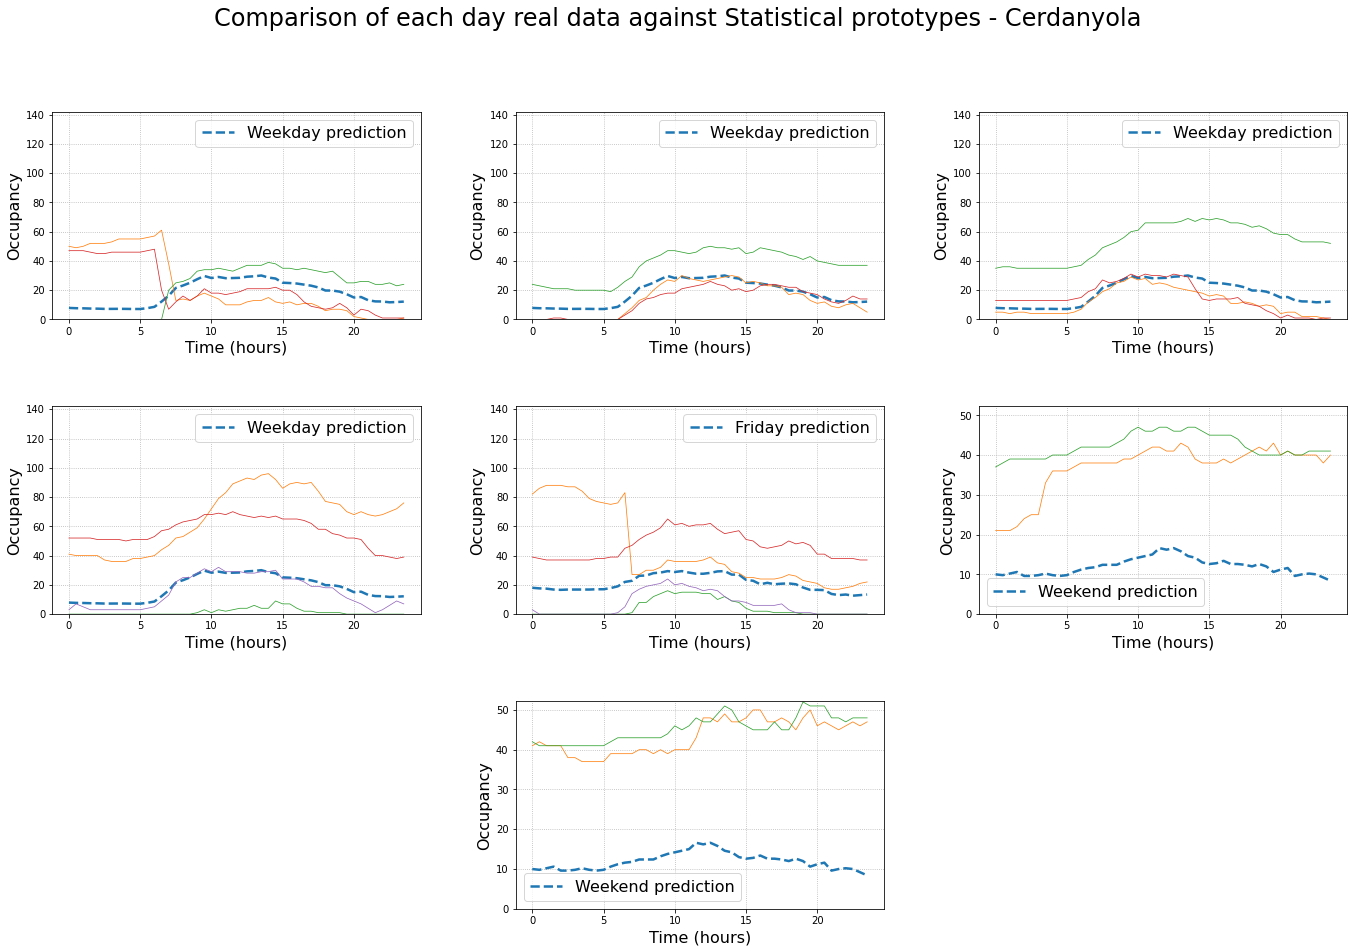

In [354]:
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(14)
fig.suptitle('Comparison of each day real data against Statistical prototypes - '+current_parking, fontsize=24)

subplot_training(fig, ax, 0, 0, Weekday_proto.values, testing_mondays, 'Monday', 'Weekday')
subplot_training(fig, ax, 0, 1, Weekday_proto.values, testing_tuesdays, 'Tuesday', 'Weekday')
subplot_training(fig, ax, 0, 2, Weekday_proto.values, testing_wednesdays, 'Wednesday', 'Weekday')
subplot_training(fig, ax, 1, 0, Weekday_proto.values, testing_thursdays, 'Thursday', 'Weekday')
subplot_training(fig, ax, 1, 1, Friday_proto.values, testing_fridays, 'Friday', 'Friday')
subplot_training(fig, ax, 1, 2, Weekend_proto.values, testing_saturdays, 'Saturday', 'Weekend')
subplot_training(fig, ax, 2, 1, Weekend_proto.values, testing_sundays, 'Sunday', 'Weekend')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
ax[2,1].set_ylim(0,axis_ylim_we)
ax[1,2].set_ylim(0,axis_ylim_we)
fig.tight_layout(pad=5)


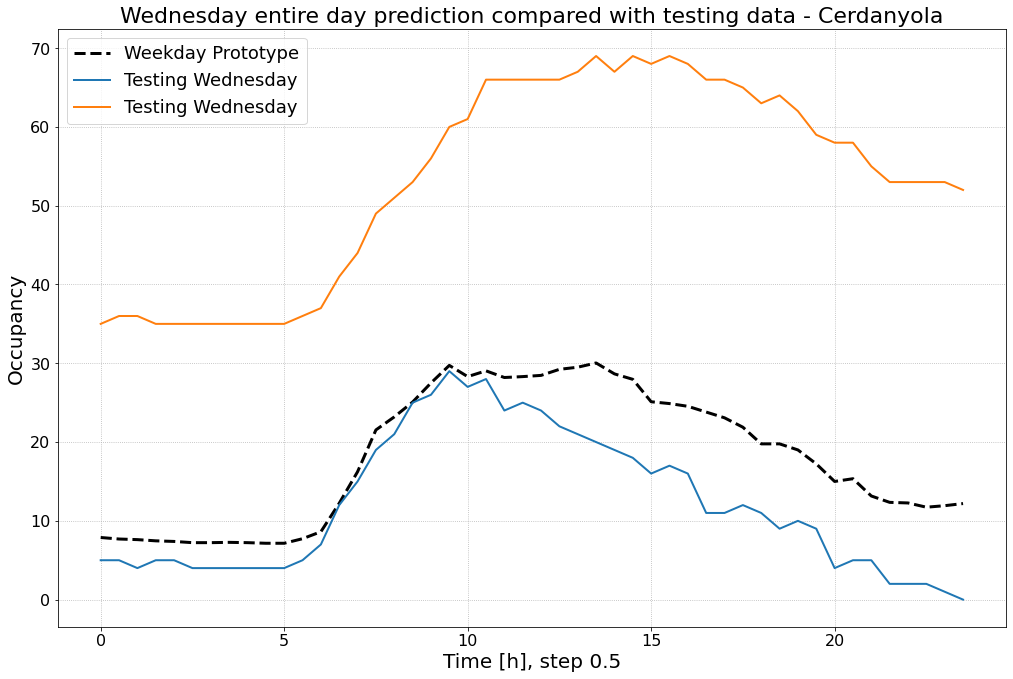

In [355]:
fig = plt.figure(figsize=(17,11))
plt.title('Wednesday entire day prediction compared with testing data - '+current_parking, fontsize = 22)
plt.plot(time, Weekday_proto.values, linestyle='dashed', linewidth=3, color='black', label='Weekday Prototype')
plt.plot(time, testing_wednesdays[0], linewidth=2, label="Testing Wednesday")
plt.plot(time, testing_wednesdays[1], linewidth=2, label="Testing Wednesday")
# plt.plot(time, testing_wednesdays[3], linewidth=2, label="Testing Wednesday")
plt.grid(linestyle='dotted')
plt.legend(fontsize=18);
plt.xlabel('Time [h], step 0.5', fontsize=20)
plt.ylabel('Occupancy', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);

#### Computing errors for 3 prototypes

In [356]:
def compute_testing_prop_error(testing_days, proto_data):
    errors = np.zeros(48)
    n_test_days = len(testing_days)
    proto = np.array(proto_data)
    
    for i in range(0, n_test_days):
        day = np.array(testing_days[i])
        er = np.array((np.absolute(proto - day)/max_value)*100)
        errors += er
    return errors/n_test_days

error_monday_stat = compute_testing_prop_error(testing_mondays, Weekday_proto.values)
error_tuesday_stat = compute_testing_prop_error(testing_tuesdays, Weekday_proto.values)
error_wednesday_stat = compute_testing_prop_error(testing_wednesdays, Weekday_proto.values)
error_thursday_stat = compute_testing_prop_error(testing_thursdays, Weekday_proto.values)
error_friday_stat = compute_testing_prop_error(testing_fridays, Friday_proto.values)
error_saturday_stat = compute_testing_prop_error(testing_saturdays, Weekend_proto.values)
error_sunday_stat = compute_testing_prop_error(testing_sundays, Weekend_proto.values)

______MEAN________
13.397392111531454
7.813375718088833
13.180214025500911
21.72229665825977
16.244023224043715
22.660519125683056
26.553961748633878
______STDV________
7.365182900090726
0.7193574700567756
3.646947661942986
3.2938518108995773
5.476007031067259
2.526064429943399
2.835182903668794


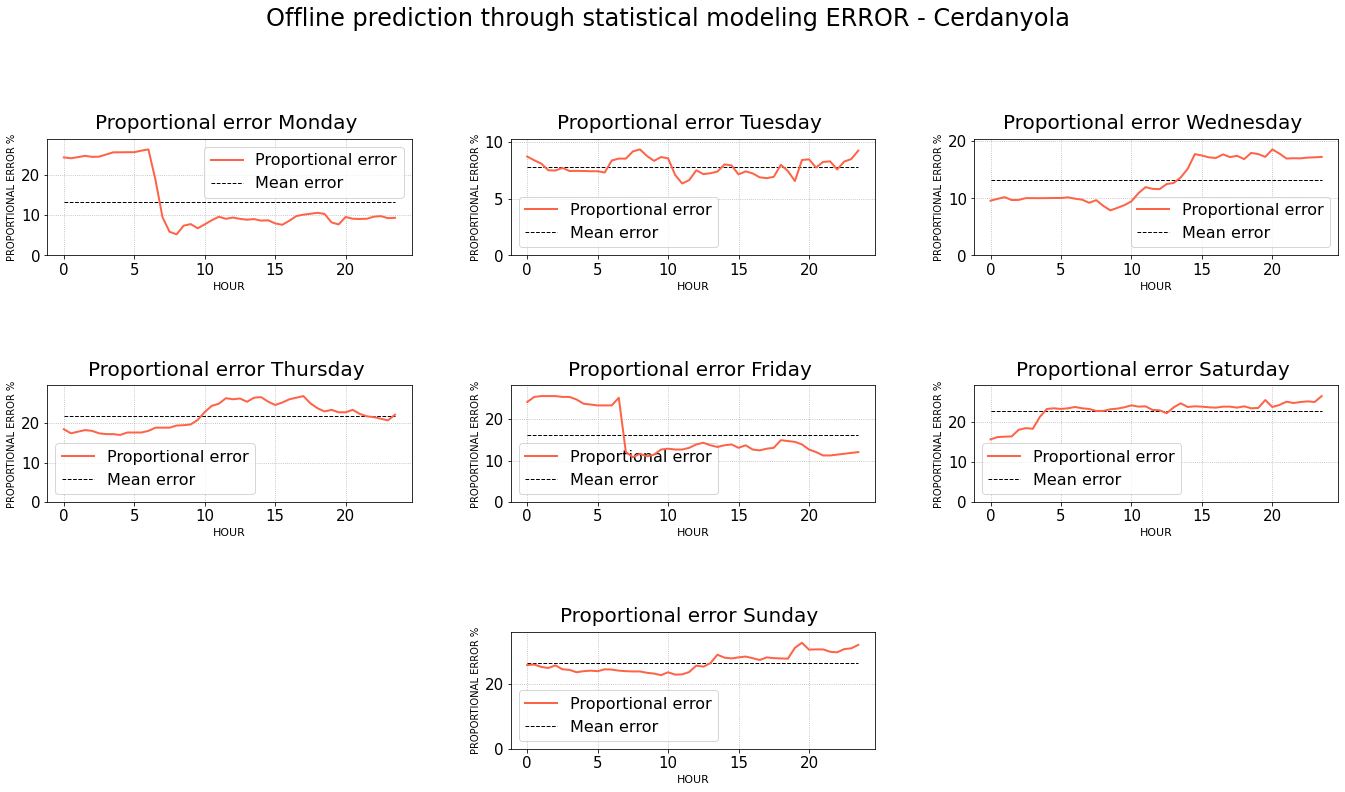

In [357]:
def subplotStatErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="tomato", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='black', label='Mean error')
    ax[axx,axy].grid(linestyle='dotted')
    ax[axx,axy].legend(loc='upper left', fontsize=10)
    ax[axx,axy].set_ylabel('Proportional error %', fontsize=20)
    ax[axx,axy].set_xlabel('Hours', fontsize=30)
    ax[axx,axy].set_title(title, pad=10, fontsize=20)
    ax[axx,axy].set_ylim((0,1.1*max(error)))
    ax[axx,axy].legend(fontsize=16)
    ax[axx,axy].tick_params( labelsize=15)
    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Offline prediction through statistical modeling ERROR - '+ current_parking, fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_stat)]*len(time)
subplotStatErr(fig, ax, 0, 0, time, error_monday_stat, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_stat)]*len(time)
subplotStatErr(fig, ax, 0, 1, time, error_tuesday_stat, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_stat)]*len(time)
subplotStatErr(fig, ax, 0, 2, time, error_wednesday_stat, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_stat)]*len(time)
subplotStatErr(fig, ax, 1, 0, time, error_thursday_stat, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_stat)]*len(time)
subplotStatErr(fig, ax, 1, 1, time, error_friday_stat, mean_Friday, 
                 'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_stat)]*len(time)
subplotStatErr(fig, ax, 1, 2, time, error_saturday_stat, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_stat)]*len(time)
subplotStatErr(fig, ax, 2, 1, time, error_sunday_stat, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in ax.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)

print('______MEAN________')
print(mean_Monday[0])
print(mean_Tuesday[0])
print(mean_Wednesday[0])
print(mean_Thursday[0])
print(mean_Friday[0])
print(mean_Saturday[0])
print(mean_Sunday[0])

print('______STDV________')

print(np.std(error_monday_stat))
print(np.std(error_tuesday_stat))
print(np.std(error_wednesday_stat))
print(np.std(error_thursday_stat))
print(np.std(error_friday_stat))
print(np.std(error_saturday_stat))
print(np.std(error_sunday_stat))

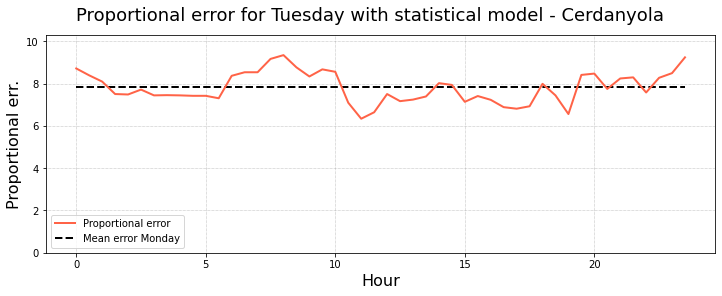

In [358]:
fig = plt.figure(figsize=(12,4))
fig.suptitle('Proportional error for Tuesday with statistical model - '+ current_parking, fontsize=18)
plt.grid(linestyle='dotted', linewidth='0.5', color='grey')
plt.plot(real_tuesday.index.tolist(), error_tuesday_stat, color="tomato", linewidth=2, zorder=10, label='Proportional error')
plt.plot(real_tuesday.index.tolist(), mean_Tuesday, linewidth=2, linestyle='--' ,color='black', label='Mean error Monday')
plt.legend()
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Proportional err.', fontsize=16)
plt.ylim([0,1.1*max(error_tuesday_stat)]);

## NORMALIZATION

In [359]:
def Area_by_date(date):
    df = df_prediction_mean
    df_day = df[(df['Date'] == date)]
    day_occ = df_day['Occupancy_mod'].values
    Area = integrate.simps(day_occ)
    return Area


def df_normalization(occ, area):
    if area == 0:
        return occ
    return occ/area

def compute_min(date):
    df_day = df[(df['Date'] == date)]
    day_occ = df_day['Occupancy'].values
    return min(day_occ)


df_prediction_mean['Min_value'] = df_prediction_mean['Date'].apply(lambda x: compute_min(x))
df_mean_offset = df_prediction_mean.groupby(['Profile_3'], as_index=False).mean() 
df_mean_offset[['Profile_3','Min_value']]

friday_offset = df_mean_offset.iloc[0]['Min_value']
weekday_offset = df_mean_offset.iloc[1]['Min_value']
weekend_offset = df_mean_offset.iloc[2]['Min_value']

df_prediction_mean['Occupancy_mod'] = df_prediction_mean['Occupancy'] - df_prediction_mean['Min_value']



In [360]:
df_prediction_mean['Area'] = df_prediction_mean['Date'].apply(lambda x: Area_by_date(x))
df_prediction_mean['Normalized_occupancy'] = df_prediction_mean.apply(lambda x: df_normalization(x.Occupancy_mod, x.Area), axis=1)
df_normalized = df_prediction_mean[['Date', 'hour','MonthNumber', 'Normalized_occupancy', 'Weekday', 'Profile_3', 'Occupancy_mod', 'Area', 'Occupancy']].copy()


df_normalized

Date  hour MonthNumber  Normalized_occupancy  Weekday Profile_3  \
0     2020-01-07   0.0          01              0.000000  Tuesday   Weekday   
1     2020-01-07   0.5          01              0.000000  Tuesday   Weekday   
2     2020-01-07   1.0          01              0.000000  Tuesday   Weekday   
3     2020-01-07   1.5          01              0.000000  Tuesday   Weekday   
4     2020-01-07   2.0          01              0.002146  Tuesday   Weekday   
...          ...   ...         ...                   ...      ...       ...   
2779  2020-03-13  21.5          03              0.000000   Friday    Friday   
2780  2020-03-13  22.0          03              0.000000   Friday    Friday   
2781  2020-03-13  22.5          03              0.000000   Friday    Friday   
2782  2020-03-13  23.0          03              0.000000   Friday    Friday   
2783  2020-03-13  23.5          03              0.000000   Friday    Friday   

      Occupancy_mod        Area  Occupancy  
0                 0  466.083333         15  
1                 0  466.083333         15  
2                 0  466.083333         15  
3                 0  466.083333         15  
4                 1  466.083333         16  
...             ...         ...        ...  
2779              0  324.250000          0  
2780              0  324.250000          0  
2781              0  324.250000          0  
2782              0  324.250000          0  
2783              0  324.250000          0  

[2784 rows x 9 columns]

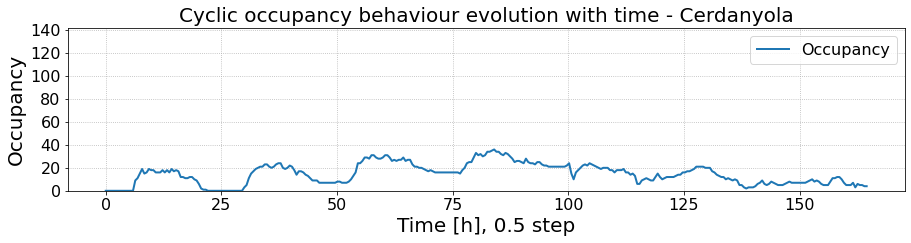

In [361]:
starting_plot = df_normalized[df_normalized['Date']=='2020-02-10'].index[0]
ending_plot = df_normalized[df_normalized['Date']=='2020-02-17'].index[0]

week = df_normalized.iloc[starting_plot:ending_plot]
week_values = week['Occupancy'].values
time = np.linspace(0,164.5,len(week))



fig, ax = plt.subplots(figsize=(15,3))
plt.plot(time, week_values, label='Occupancy', linewidth=2)
plt.title('Cyclic occupancy behaviour evolution with time - '+current_parking, fontsize = 20)
plt.xlabel('Time [h], 0.5 step', fontsize = 20)
plt.ylabel('Occupancy', fontsize = 20)
plt.ylim([0,axis_ylim])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='dotted')
plt.legend(fontsize=16);

In [362]:
def split_data(df, n_test_weeks, limit_date = None, from_end=True): 
    if(limit_date != None):
        init_test = df[df['Date']==limit_date].index[0];
        end_test = df.shape[0]
        test_domain = range(init_test, end_test)
        test_domain = list(test_domain)

    else:
        if(from_end == True):
            end_test = df.shape[0]
            week_domain = n_test_weeks*336
            init_test = end_test-week_domain
            test_domain = range(init_test, end_test)
            test_domain = list(test_domain)
            
        elif(from_end == False):
            week_domain = n_test_weeks*336
            init_test = 0
            end_test = week_domain
            test_domain = range(0,week_domain)
            test_domain = list(test_domain)
            
    test_df = df[init_test:end_test]
    training_df = df.drop(test_domain)
    return training_df, test_df

In [363]:
df_training, df_testing = split_data(df_normalized, 3)

In [364]:
#pd.set_option('display.max_rows', None)
#df_testing.sort_values(by='Area', ascending=True)

In [365]:
#pd.set_option('display.max_rows', 5)

In [366]:
df_training['Area'] = df_training['Date'].apply(lambda x: Area_by_date(x))
df_training

df_mean_areas = df_training.groupby(['Profile_3'], as_index=False).mean() 
df_mean_areas[['Profile_3', 'Area']]

friday_area = df_mean_areas.iloc[0]['Area']
weekday_area = df_mean_areas.iloc[1]['Area']
weekend_area = df_mean_areas.iloc[2]['Area']

print('Weekday area: ' , weekday_area)
print('Friday area: ' , friday_area)
print('Weekend area: ' , weekend_area)

# df_normalized

Weekday area:  559.153846153848
Friday area:  454.26388888889045
Weekend area:  244.2499999999996


In [367]:
def get_days_normalized(dayname, df_):
    data_temp = df_[df_['Weekday'] == dayname] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Normalized_occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
    return days

def get_days_of_protos_normalized(proto_name, df_):
    data_temp = df_[df_['Profile_3'] == proto_name] 
    days = []
    for i in range(0,data_temp.shape[0], 48):
        day = data_temp['Normalized_occupancy'][i:i+48]
        if len(day) == 48:
            days.append(day)
        
    return days

In [368]:
# ------------------------ NEW TESTING DATA -----------------------------
# these variables are arrays of days
testing_mondays_norm    = get_days_normalized("Monday", df_testing)
testing_tuesdays_norm   = get_days_normalized("Tuesday", df_testing)
testing_wednesdays_norm = get_days_normalized("Wednesday", df_testing)
testing_thursdays_norm  = get_days_normalized("Thursday", df_testing)
testing_fridays_norm    = get_days_normalized("Friday", df_testing)
testing_saturdays_norm  = get_days_normalized("Saturday", df_testing)
testing_sundays_norm    = get_days_normalized("Sunday", df_testing)

testing_mondays    = get_days("Monday", df_testing)
testing_tuesdays   = get_days("Tuesday", df_testing)
testing_wednesdays = get_days("Wednesday", df_testing)
testing_thursdays  = get_days("Thursday", df_testing)
testing_fridays    = get_days("Friday", df_testing)
testing_saturdays  = get_days("Saturday", df_testing)
testing_sundays    = get_days("Sunday", df_testing)

In [369]:
training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
# for ii in range(len(training_weekdays_norm)):
#     plt.plot(time,training_weekdays_norm[ii])

In [370]:
pd.set_option("max_rows", None)
df_training[df_training.Weekday=='Sunday']
pd.set_option("max_rows", 10)

In [371]:
def plot_model_tn_pres(loc_ar=.3, scale_ar=.05, loc_de=.8, scale_de=.1):
    # arrivals
    a_ar = -loc_ar/scale_ar
    b_ar = (1-loc_ar)/scale_ar

    # departures
    a_de = -loc_de/scale_de
    b_de = (1-loc_de)/scale_de

    pdf_ar = truncnorm.pdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    pdf_de = truncnorm.pdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)
    cdf_ar = truncnorm.cdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    cdf_de = truncnorm.cdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)

    xlims = [0, 23.58]
    ylims = [-0.2, 8.2]
    figsize = (10,5)
    
    if False:
        fig, ax = plt.subplots(figsize=figsize)
        plt.plot(time, pdf_ar, '-b', label='arribades', linewidth=2)
        plt.xlabel('temps (x)', fontsize = 20)
        plt.title('Densitat de probabilitat', fontsize = 20)
        plt.xlim(xlims)
        plt.ylim(ylims)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(linestyle='dotted')
        plt.legend(fontsize=16)
        plt.legend(fontsize=16)
    
        fig, ax = plt.subplots(figsize=figsize)
        plt.plot(time, pdf_de, '-r', label='sortides', linewidth=2)
        plt.xlabel('temps (x)', fontsize = 20)
        plt.title('Densitat de probabilitat', fontsize = 20)
        plt.xlim(xlims)
        plt.ylim(ylims)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(linestyle='dotted')
        plt.legend(fontsize=16)
        plt.legend(fontsize=16)
    
        fig, ax = plt.subplots(figsize=figsize)
        plt.plot(time, pdf_ar, '-b', label='arribades', linewidth=2)
        plt.plot(time, pdf_de, '-r', label='sortides', linewidth=2)
        plt.xlabel('temps (x)', fontsize = 20)
        plt.title('Densitat de probabilitat', fontsize = 20)
        plt.xlim(xlims)
        plt.ylim(ylims)  
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(linestyle='dotted')
        plt.legend(fontsize=16)
        plt.legend(fontsize=16)
    
        fig, ax = plt.subplots(figsize=figsize)
        plt.plot(time, cdf_ar, '--b', label='sa:suma d\'arribades', linewidth=2)
        plt.plot(time, cdf_de, '--r', label='ss:suma de sortides',  linewidth=2)
        #ax[1].plot(time, cdf_ar , '--b')
        #ax[1].plot(time, cdf_de, '--r')
        #ax[1].plot(time, cdf_ar-cdf_de, 'r')
        plt.xlabel('temps (x)', fontsize = 20)
        plt.title('Probabilitat acumulada', fontsize = 20)
        plt.xlim(xlims)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid(linestyle='dotted')
        plt.legend(fontsize=16, loc='upper left')
        
    plt.plot(time, cdf_ar, '--b', label='sa:suma d\'arribades', linewidth=2)
    plt.plot(time, cdf_de, '--r', label='ss:suma de sortides',  linewidth=2)
    #ax[1].plot(time, cdf_ar , '--b')
    #ax[1].plot(time, cdf_de, '--r')
    #ax[1].plot(time, cdf_ar-cdf_de, 'r')
    plt.plot(time, cdf_ar-cdf_de, 'k',label='Resta sa-ss', linewidth=3)
    plt.xlabel('temps (x)', fontsize = 20)
    plt.title('Probabilitat acumulada', fontsize = 20)
    plt.xlim(xlims)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(linestyle='dotted')
    plt.legend(fontsize=16, loc='upper left')
    
    plt.show()

## MATHEMATICAL MODEL - CDF Subtraction

In [372]:
# ********************************************** WEEKDAY *************************************************************
#from scipy.special import tna, factorial
from scipy.stats import truncnorm 
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
time = np.linspace(0,23.5,48)
time_tn=time/24

def generate_cdf(data):
    cumulative=[0]
    for ii in range(1,len(data)):
        cumulative.append(sum(data[:ii]))
    return cumulative/sum(data)

 
def tn(x, loc, scale):
    a = -loc/scale
    b = (1-loc)/scale
    return truncnorm.pdf(x, a, b, loc, scale)


def tn_cdf(x, loc, scale):
    a = -loc/scale
    b = (1-loc)/scale
    return truncnorm.cdf(x, a, b, loc, scale)


training_weekdays_norm  = get_days_of_protos_normalized("Weekday", df_training)
training_fridays_norm  = get_days_of_protos_normalized("Friday", df_training)
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekends_norm = training_weekends_norm[:-1]
# t = []
# for i in range(0,len(training_weekends_norm)):
#     if training_weekends_norm[i].mean() != 0:
#         t.append(training_weekends_norm[i])
        
# training_weekends_norm = t
wd_length = len(training_weekdays_norm)
f_length = len(training_fridays_norm)
we_length = len(training_weekends_norm)


def model_weekdays_tn(params): 
    loc_ar = params[0]
    scale_ar = params[1]
    loc_de = params[2]
    scale_de = params[3]
 
    
     # arrivals
    #a_ar = -loc_ar/scale_ar
    #b_ar = (1-loc_ar)/scale_ar

    # departures
    #a_de = -loc_de/scale_de
    #b_de = (1-loc_de)/scale_de
    
    # make tn for arrivals
    # arrival_pdf = tn(time_tn, loc_ar, scale_ar)
    # make tn for departures
    # departure_pdf = tn(time_tn, loc_de, scale_de)
    # compute CDF for arrivals
    # arrival_cdf = generate_cdf(arrival_pdf)
    
    # compute CDF for departures
    # departure_cdf = generate_cdf(departure_pdf)
    #cdf_ar = truncnorm.cdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    #cdf_de = truncnorm.cdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)
    cdf_ar=tn_cdf(time_tn, loc_ar, scale_ar)
    cdf_de=tn_cdf(time_tn, loc_de, scale_de)

    #res = np.array(arrival_cdf) - np.array(departure_cdf)
    #res_n = res/sum(res)
    
    #res = np.array(cdf_ar) - np.array(cdf_de)
    res = cdf_ar - cdf_de
    res_n = res/sum(res)
  
    #res_n[res_n>thresh] = thresh
    #plt.plot(res_n)
    #plt.show()
    error = 0  
    for ii in range(0,wd_length):
        day = training_weekdays_norm[ii]
        error += mean_squared_error(res_n, day)

    #plot_model_tn_pres(loc_ar, scale_ar, loc_de, scale_de) 
    #print("mua = " + str(loc_ar) + "\tstda  = " + str(scale_ar))
    #print("mus = " + str(loc_de) + "\tstds = " + str(scale_de))
    #print("Err = " + str(error))
    return error



# params order = a1, b1, a2, b2, rescale
# params order: loc_ar=.3, scale_ar=.05, loc_de=.8, scale_de=.1, rescale
#parameters = np.array([ 2 , 20, 5, 80, 0.02])
#parameters_tn = np.array([.3 ,.05,.8,.1])
parameters_tn = np.array([.2 ,.05,.7,.1])
#optimal_params_weekday = minimize(model_weekdays, parameters, method='Nelder-Mead', tol=0.01)
#optimal_params_weekdaytn = minimize(model_weekdays_tn, parameters_tn, method='Nelder-Mead', tol=0.01)
optimal_params_weekdaytn = minimize(model_weekdays_tn, parameters_tn, method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})


Optimization terminated successfully.
         Current function value: 0.001112
         Iterations: 168
         Function evaluations: 283


In [373]:
optimal_params_weekdaytn

 final_simplex: (array([[0.30036088, 0.0552915 , 0.92546002, 0.25338746],
       [0.30036085, 0.05529152, 0.92545937, 0.25338704],
       [0.30036082, 0.05529153, 0.92545992, 0.25338754],
       [0.30036086, 0.05529153, 0.925461  , 0.25338799],
       [0.30036078, 0.0552914 , 0.92546026, 0.25338725]]), array([0.00111241, 0.00111241, 0.00111241, 0.00111241, 0.00111241]))
           fun: 0.0011124147962404726
       message: 'Optimization terminated successfully.'
          nfev: 283
           nit: 168
        status: 0
       success: True
             x: array([0.30036088, 0.0552915 , 0.92546002, 0.25338746])

In [374]:
def plot_model_tn(loc_ar=.3, scale_ar=.05, loc_de=.8, scale_de=.1):
    # arrivals
    a_ar = -loc_ar/scale_ar
    b_ar = (1-loc_ar)/scale_ar

    # departures
    a_de = -loc_de/scale_de
    b_de = (1-loc_de)/scale_de


    pdf_ar = truncnorm.pdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    pdf_de = truncnorm.pdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)
    cdf_ar = truncnorm.cdf(time_tn, a_ar, b_ar, loc=loc_ar, scale=scale_ar)
    cdf_de = truncnorm.cdf(time_tn, a_de, b_de, loc=loc_de, scale=scale_de)

    fig, ax = plt.subplots(2)
    ax[0].plot(time, pdf_ar , '-b')
    ax[0].plot(time, pdf_de, '-r')
    ax[0].set_title('pdfs')

    ax[1].plot(time, cdf_ar , '--b')
    ax[1].plot(time, cdf_de, '--r')
    ax[1].plot(time, cdf_ar-cdf_de, 'r')
    ax[1].set_title('cdfs')

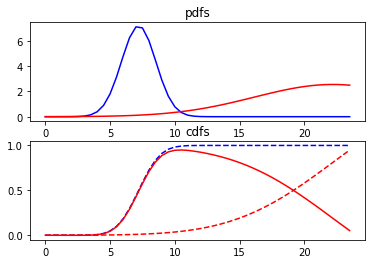

In [375]:
plot_model_tn(optimal_params_weekdaytn.x[0],optimal_params_weekdaytn.x[1],optimal_params_weekdaytn.x[2],optimal_params_weekdaytn.x[3])

In [376]:
weekday_math_params = optimal_params_weekdaytn.x
weekday_math_params

array([0.30036088, 0.0552915 , 0.92546002, 0.25338746])

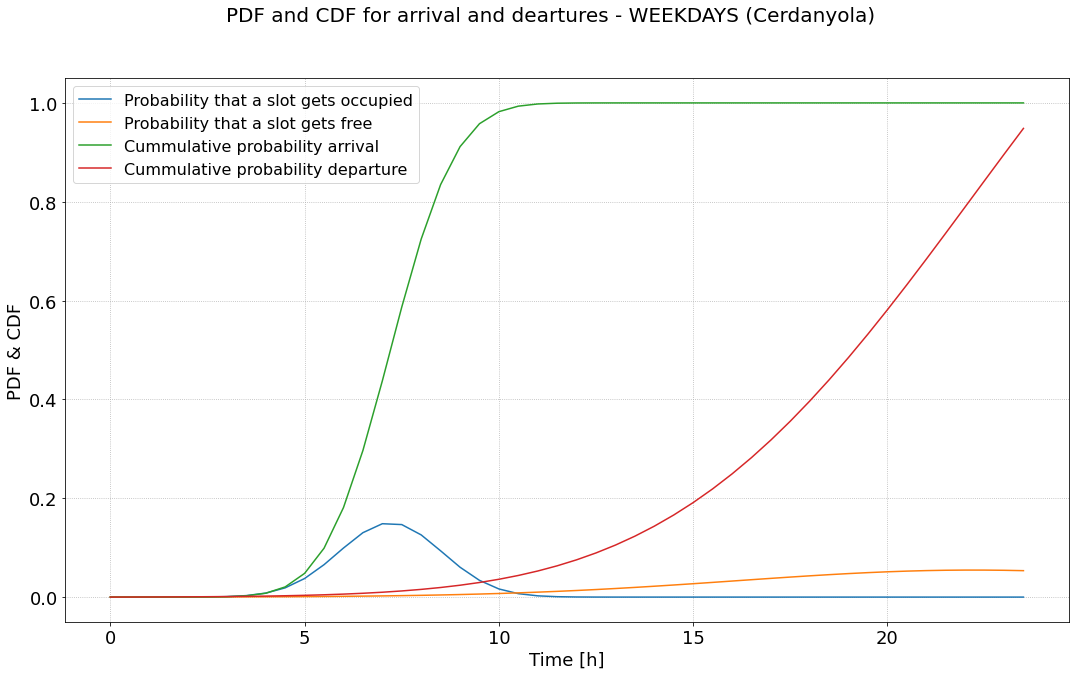

In [377]:
time2 = np.linspace(0,23.5,48)
tn1_wd=tn(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
tn2_wd=tn(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#tn1_wd = gam(time2, optimal_params_weekday.x[0], optimal_params_weekday.x[1])
#tn2_wd = gam(time2, optimal_params_weekday.x[2], optimal_params_weekday.x[3])

#cdf1_wd_ap = generate_cdf(tn1_wd)
#cdf2_wd_ap = generate_cdf(tn2_wd)
cdf1_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[0], optimal_params_weekdaytn.x[1])
cdf2_wd = tn_cdf(time_tn, optimal_params_weekdaytn.x[2], optimal_params_weekdaytn.x[3])
#cdf1_wd = generate_cdf(tn1_wd)
#cdf2_wd = generate_cdf(tn2_wd)

resta_wd = np.array(cdf1_wd) - np.array(cdf2_wd)
prototype_math_weekday = resta_wd/sum(resta_wd)

#resta_wd_ap= np.array(cdf1_wd_ap) - np.array(cdf2_wd_ap)
#prototype_math_weekday_ap = resta_wd_ap/sum(resta_wd_ap)

fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for arrival and deartures - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.plot(time2, tn1_wd/sum(tn1_wd), label="Probability that a slot gets occupied")
plt.plot(time2, tn2_wd/sum(tn2_wd),  label="Probability that a slot gets free")
plt.plot(time2, cdf1_wd, label="Cummulative probability arrival")
plt.plot(time2, cdf2_wd, label="Cummulative probability departure")
#plt.plot(time2, cdf1_wd_ap, label="Cummulative probability arrival approx")
#plt.plot(time2, cdf2_wd_ap, label="Cummulative probability departure approx")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left");


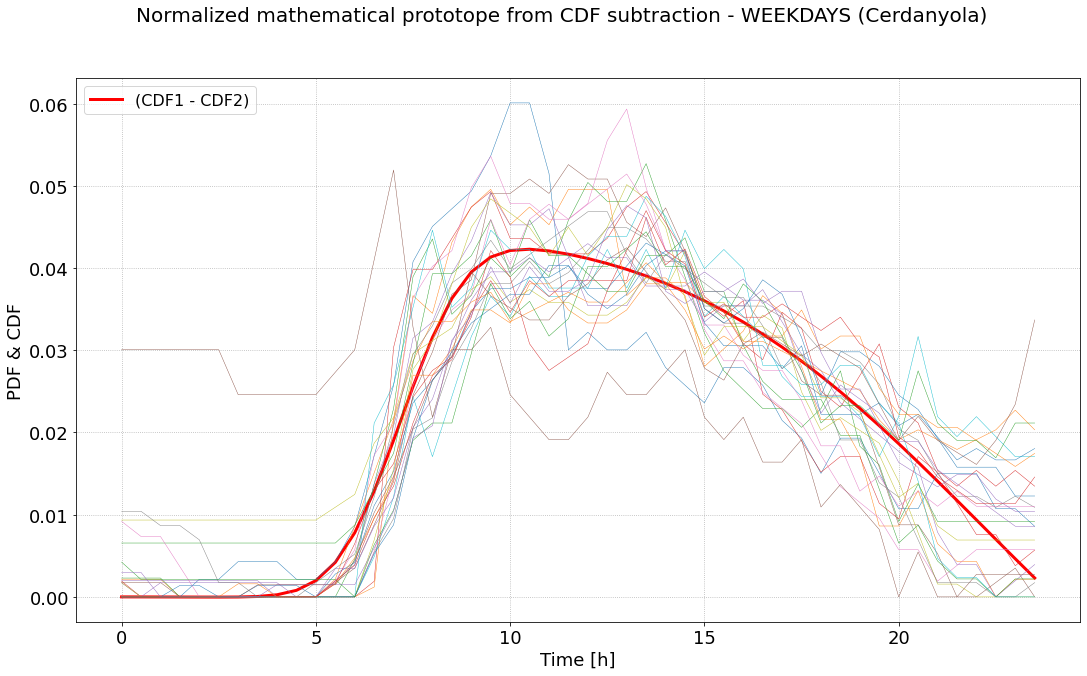

In [378]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time2, prototype_math_weekday, linewidth=3, color='red', label="(CDF1 - CDF2)")
#plt.plot(time2, prototype_math_weekday_ap, linewidth=3, color='red', label="approx")
for i in range(0,len(training_weekdays_norm)):
    plt.plot(time, training_weekdays_norm[i], linewidth=0.45)

plt.legend(fontsize=16, loc="upper left");

### FRIDAYS

In [379]:
def model_fridays_tn(params): 
    loc_ar = params[0]
    scale_ar = params[1]
    loc_de = params[2]
    scale_de = params[3]
    error = 0
    # make tn for arrivals
    arrival_cdf = tn_cdf(time_tn, loc_ar, scale_ar)
    # make tn for departures
    departure_cdf = tn_cdf(time_tn, loc_de, scale_de)
    # compute CDF for arrivals
    #arrival_cdf = generate_cdf(arrival_pdf)
    # compute CDF for departures
    #departure_cdf = generate_cdf(departure_pdf)
    #res = np.array(arrival_cdf) - np.array(departure_cdf)
    res =arrival_cdf - departure_cdf
    res_n = res/sum(res)
    
    for ii in range(0,f_length):
        day = training_fridays_norm[ii]
        error += mean_squared_error(res_n, day)
    return error


# params order = a1, b1, a2, b2
#parameters = np.array([ 2 , 20, 5, 80, 0.02])
#optimal_params_friday = minimize(model_fridays, parameters, method='Nelder-Mead', tol=0.01)

# params order: loc_ar=.3, scale_ar=.05, loc_de=.8, scale_de=.1, rescale
#parameters_tn = np.array([.3 ,.05,.8,.1])
#optimal_params_fridaytn = minimize(model_fridays_tn, parameters_tn, method='Nelder-Mead', tol=0.01)

parameters_tn = np.array([.2 ,.05,.7,.1])
optimal_params_fridaytn = minimize(model_fridays_tn, parameters_tn, method='Nelder-Mead',
                                    tol=1e-6, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000592
         Iterations: 237
         Function evaluations: 394


In [380]:
optimal_params_fridaytn

 final_simplex: (array([[0.24453507, 0.14105349, 0.69562037, 0.35231557],
       [0.24453496, 0.14105363, 0.69562044, 0.35231589],
       [0.2445351 , 0.14105357, 0.6956198 , 0.35231614],
       [0.24453505, 0.14105364, 0.6956197 , 0.35231548],
       [0.2445351 , 0.14105366, 0.69561995, 0.35231554]]), array([0.00059214, 0.00059214, 0.00059214, 0.00059214, 0.00059214]))
           fun: 0.0005921422622071853
       message: 'Optimization terminated successfully.'
          nfev: 394
           nit: 237
        status: 0
       success: True
             x: array([0.24453507, 0.14105349, 0.69562037, 0.35231557])

In [381]:
#optimal_params_friday.x
#friday_math_params = optimal_params_friday.x
friday_math_params = optimal_params_fridaytn.x

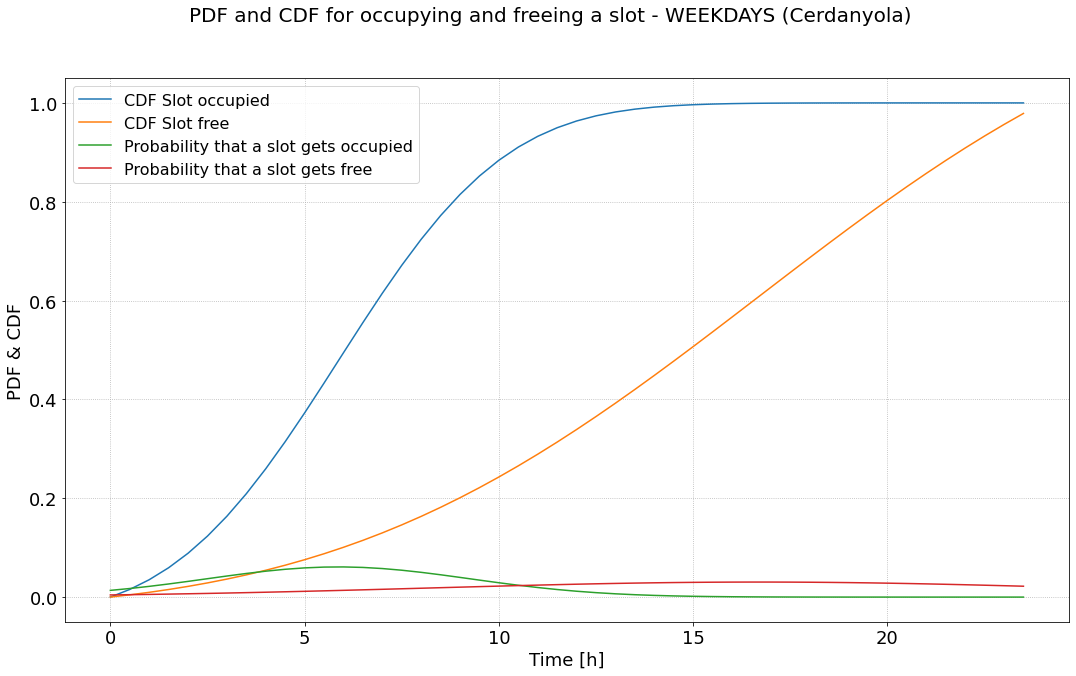

In [382]:

#tn1_fri = gam(time, optimal_params_friday.x[0], optimal_params_friday.x[1])
#tn2_fri = gam(time, optimal_params_friday.x[2], optimal_params_friday.x[3])
tn1_fri=tn(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
tn2_fri=tn(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
#cdf1_fri = generate_cdf(tn1_fri)
#cdf2_fri = generate_cdf(tn2_fri)
cdf1_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[0], optimal_params_fridaytn.x[1])
cdf2_fri=tn_cdf(time_tn, optimal_params_fridaytn.x[2], optimal_params_fridaytn.x[3])

resta = np.array(cdf1_fri) - np.array(cdf2_fri)
prototype_math_friday = resta/sum(resta)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKDAYS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_fri, label="CDF Slot occupied")
plt.plot(time, cdf2_fri, label="CDF Slot free")
plt.plot(time, tn1_fri/sum(tn1_fri), label="Probability that a slot gets occupied")
plt.plot(time, tn2_fri/sum(tn2_fri),  label="Probability that a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

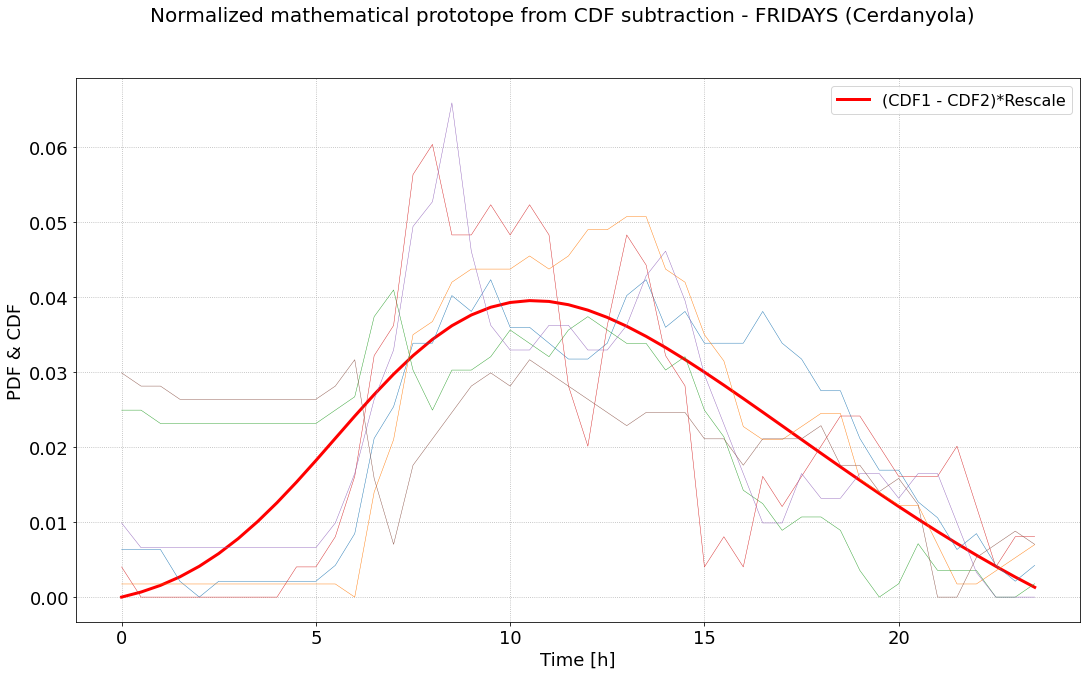

In [383]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - FRIDAYS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_friday, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_fridays_norm)):
    plt.plot(time, training_fridays_norm[i], linewidth=0.45)
plt.legend(fontsize=16)

### WEEKENDS

In [384]:
training_weekends_norm  = get_days_of_protos_normalized("Weekend", df_training)
training_weekends_norm = training_weekends_norm[:-1]
t = []
for i in range(0,len(training_weekends_norm)):
    if training_weekends_norm[i].mean() != 0:
        t.append(training_weekends_norm[i])
        
training_weekends_norm = t
we_length = len(t)

def model_weekends_tn(params): 
    loc_ar = params[0]
    scale_ar = params[1]
    loc_de = params[2]
    scale_de = params[3]
    error = 0
    # make tn for arribals
    #arrival_pdf = tn(time_tn, loc_ar, scale_ar)
    # make tn for departures
    #departure_pdf = tn(time_tn, loc_de, scale_de)
    # compute CDF for arribals
    #arrival_cdf = generate_cdf(arrival_pdf)
    # compute CDF for departures
    #departure_cdf = generate_cdf(departure_pdf)
    
    arrival_cdf = tn_cdf(time_tn, loc_ar, scale_ar)
    departure_cdf = tn_cdf(time_tn, loc_de, scale_de)
    res =arrival_cdf - departure_cdf
    
    #res = np.array(arrival_cdf) - np.array(departure_cdf)
    res_n = res/sum(res)
    
    #print(loc_de)
    #print(scale_de)
    #print(departure_cdf)
    
    for ii in range(0,we_length):
        day = training_weekends_norm[ii]
        error += mean_squared_error(res_n, day)
        
        
        
    #plot_model_tn_pres(loc_ar, scale_ar, loc_de, scale_de) 
    #print("mua = " + str(loc_ar) + "\tstda  = " + str(scale_ar))
    #print("mus = " + str(loc_de) + "\tstds = " + str(scale_de))
    #print("Err = " + str(error))     

    return error


# params order = a1, b1, a2, b2
#parameters = np.array([ 2 , 20, 5, 80, 2])
#optimal_params_weekend = minimize(model_weekends, parameters, method='Nelder-Mead', tol=0.01)

# params order: loc_ar=.3, scale_ar=.05, loc_de=.8, scale_de=.1, rescale
parameters_tn = np.array([.3 ,.1,.8,0.5])
#optimal_params_weekendtn = minimize(model_weekends_tn, parameters_tn, method='Nelder-Mead', tol=0.01)
#optimal_params_weekendtn = minimize(model_weekends_tn, parameters_tn, method='Nelder-Mead',
#                                    tol=1e-6, options={'disp': True})
if ((current_parking == "SantBoi") or (current_parking == "Cerdanyola")): 
    optimal_params_weekendtn = minimize(model_weekends_tn, parameters_tn, method='SLSQP',
                                        bounds=((0, None), (0, None),(0, None),(0, None)),
                                        tol=1e-6, options={'disp': True})
else:
    optimal_params_weekendtn = minimize(model_weekends_tn, parameters_tn, method='Nelder-Mead',
                                        tol=1e-6, options={'disp': True})  

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.0009079942911198731
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 6


In [385]:
#weekend_math_params = optimal_params_weekend.x
#optimal_params_weekend.x
weekend_math_params = optimal_params_weekendtn.x
optimal_params_weekendtn.x

array([0.31898954, 0.18021385, 0.80703338, 0.49424818])

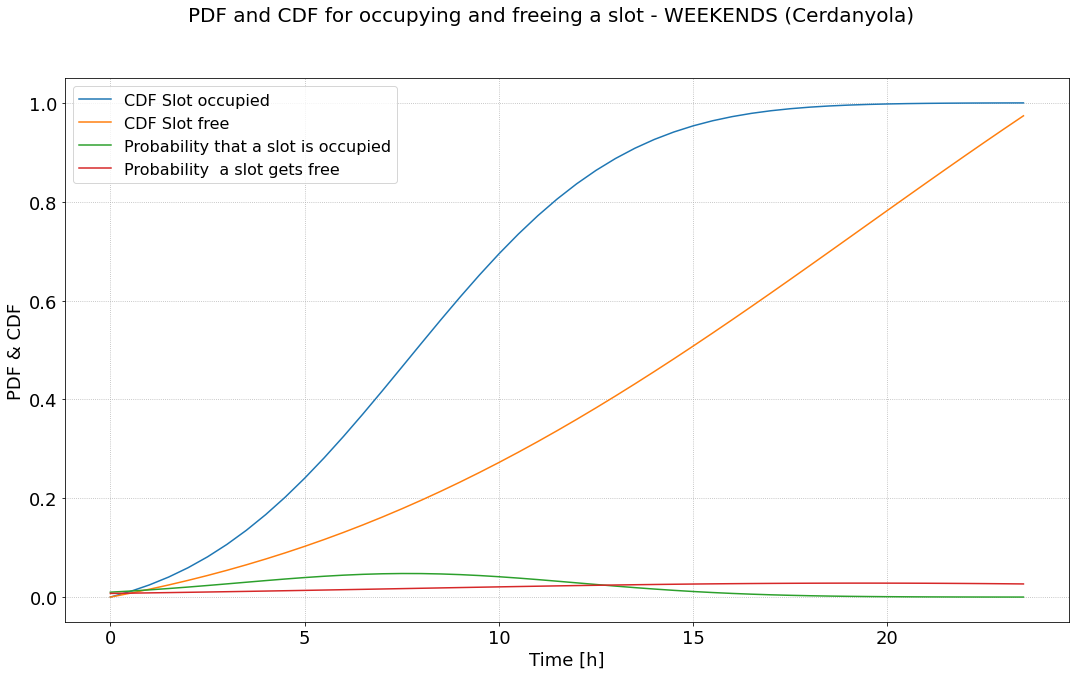

In [386]:
#tn1_we = gam(time, optimal_params_weekend.x[0], optimal_params_weekend.x[1])
#tn2_we = gam(time, optimal_params_weekend.x[2], optimal_params_weekend.x[3])
tn1_we=tn(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
tn2_we=tn(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



#cdf1_we = generate_cdf(tn1_we)
#cdf2_we = generate_cdf(tn2_we)
cdf1_we = tn_cdf(time_tn, optimal_params_weekendtn.x[0], optimal_params_weekendtn.x[1])
cdf2_we = tn_cdf(time_tn, optimal_params_weekendtn.x[2], optimal_params_weekendtn.x[3])



resta_we = np.array(cdf1_we) - np.array(cdf2_we)
prototype_math_weekend = resta_we/sum(resta_we)
fig = plt.figure(figsize=(18,10))
fig.suptitle("PDF and CDF for occupying and freeing a slot - WEEKENDS ("+current_parking+")", fontsize=20)
plt.plot(time, cdf1_we, label="CDF Slot occupied")
plt.plot(time, cdf2_we, label="CDF Slot free")
plt.plot(time, tn1_we/sum(tn1_we), label="Probability that a slot is occupied")
plt.plot(time, tn2_we/sum(tn2_we),  label="Probability  a slot gets free")
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.legend(fontsize=16, loc="upper left")

plt.legend(fontsize=16)

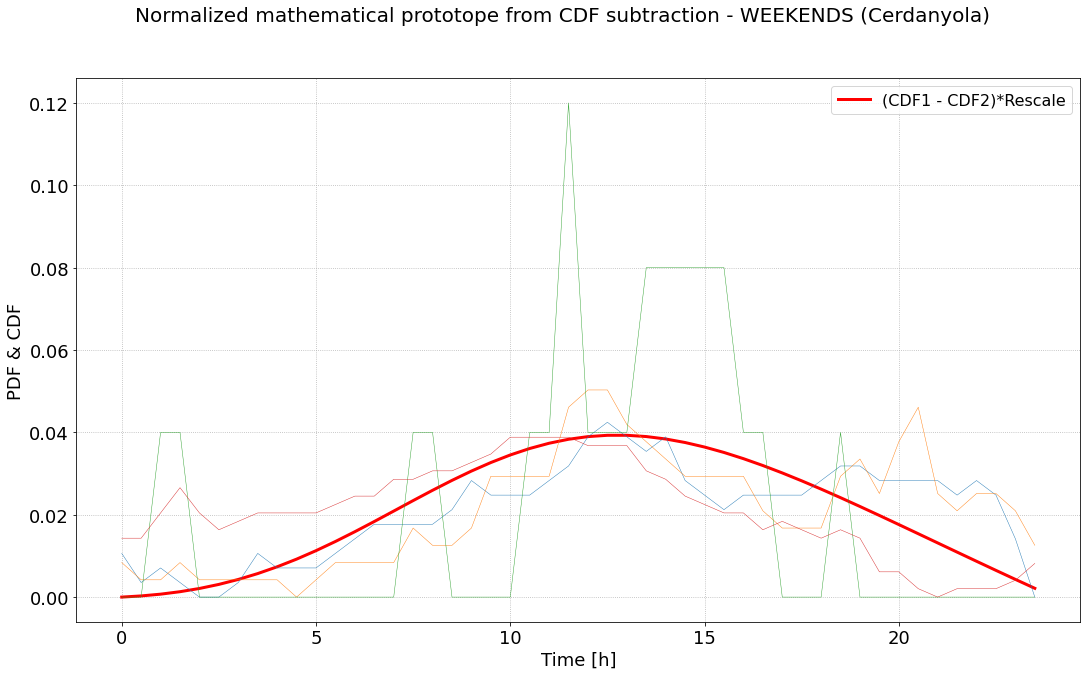

In [387]:
fig = plt.figure(figsize=(18,10))
fig.suptitle("Normalized mathematical prototope from CDF subtraction - WEEKENDS ("+current_parking+")", fontsize=20)
plt.grid(linestyle='dotted')
plt.xlabel("Time [h]", fontsize=18)
plt.ylabel("PDF & CDF", fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.plot(time, prototype_math_weekend, linewidth=3, color='red', label="(CDF1 - CDF2)*Rescale")
for i in range(0,len(training_weekends_norm)):
    plt.plot(time, training_weekends_norm[i], linewidth=0.45)
plt.legend(fontsize=16)

In [388]:
tn_weekday_n = prototype_math_weekday
tn_friday_n = prototype_math_friday
tn1_weekend_n = prototype_math_weekend

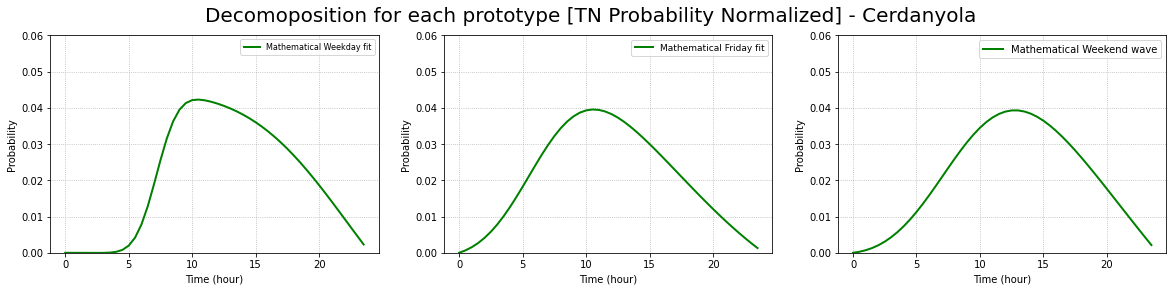

In [389]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [TN Probability Normalized] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time2, tn_weekday_n, linewidth=2, color= 'green', label='Mathematical Weekday fit')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time2, tn_friday_n, linewidth=2, color= 'green', label='Mathematical Friday fit')
ax[1].set_ylim([0,0.06])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends_norm)):
#      ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time2, tn1_weekend_n, linewidth=2, color='green', label='Mathematical Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability');

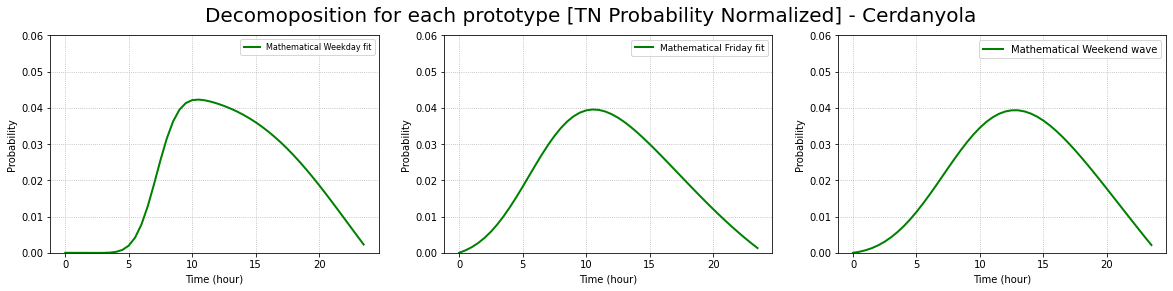

In [390]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [TN Probability Normalized] - ' + current_parking, fontsize=20)

# for ii in range(len(training_weekdays_norm)):
#     ax[0].plot(time,training_weekdays_norm[ii], linewidth='0.5')
ax[0].plot(time, tn_weekday_n, linewidth=2, color= 'green', label='Mathematical Weekday fit')
ax[0].set_ylim([0,0.06])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays_norm)):
#     ax[1].plot(time,training_fridays_norm[ii], linewidth='0.5')
ax[1].plot(time, tn_friday_n, linewidth=2, color= 'green', label='Mathematical Friday fit')
ax[1].set_ylim([0,0.06])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

# CHECK THIS
Area = integrate.simps(tn1_weekend_n) 
tn1_weekend_n = tn1_weekend_n/Area

# for ii in range(len(training_weekends_norm)):
#      ax[2].plot(time,training_weekends_norm[ii], linewidth='0.5')
ax[2].plot(time, tn1_weekend_n, linewidth=2, color='green', label='Mathematical Weekend wave')
ax[2].set_ylim([0,0.06])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability');

In [391]:
#**************************************WEEKDAY************************************
tn_weekday = tn_weekday_n*weekday_area + weekday_offset

#**************************************FRIDAY************************************
tn_friday = tn_friday_n*friday_area + friday_offset

#**************************************WEEKEND************************************
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

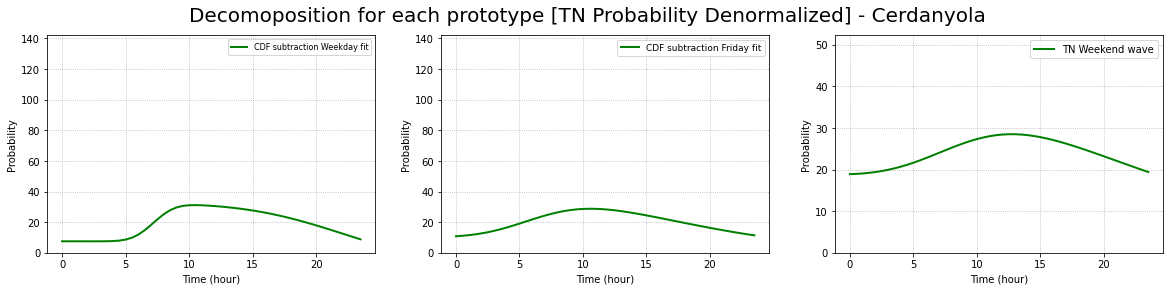

In [392]:
fig, ax = plt.subplots(1,3)
fig.set_figwidth(20)
fig.set_figheight(4)
fig.suptitle('Decomoposition for each prototype [TN Probability Denormalized] - ' + current_parking , fontsize=20)

# for ii in range(len(training_weekdays)):
#     ax[0].plot(time,training_weekdays[ii], linewidth='0.5')
ax[0].plot(time, tn_weekday, linewidth=2, color= 'green', label='CDF subtraction Weekday fit')
ax[0].set_ylim([0,axis_ylim])
ax[0].grid(linestyle='dotted')
ax[0].legend(fontsize=8)
ax[0].set_xlabel('Time (hour)')
ax[0].set_ylabel('Probability')

# for ii in range(len(training_fridays)):
#     ax[1].plot(time,training_fridays[ii], linewidth='0.5')
ax[1].plot(time, tn_friday, linewidth=2, color= 'green', label='CDF subtraction Friday fit')
ax[1].set_ylim([0,axis_ylim])
ax[1].grid(linestyle='dotted')
ax[1].legend(fontsize=9)
ax[1].set_xlabel('Time (hour)')
ax[1].set_ylabel('Probability')

# for ii in range(len(training_weekends)):
#     ax[2].plot(time,training_weekends[ii], linewidth='0.5')
ax[2].plot(time, tn1_weekend, linewidth=2, color='green', label='TN Weekend wave')
ax[2].set_ylim([0,axis_ylim_we])
ax[2].grid(linestyle='dotted')
ax[2].legend()
ax[2].set_xlabel('Time (hour)')
ax[2].set_ylabel('Probability');
# ax[2].set_yticks([0,0.005,0.01])
# ax[2].set_yticks(["0","0.05","0.1"])

### Comparing normalized mathematical fitted prototype with testing data

In [393]:
def subplot_training(fig, ax, xx, yy, proto_data, test_days, day, proto_name): 
    ax[xx,yy].plot(time, proto_data, linewidth=3, linestyle='dashed', label= proto_name + ' TN prediction')
    for i in range(0, len(test_days)): 
        ax[xx, yy].plot(time, test_days[i], linewidth=1, label='Testing ' + day )
        if i==0:
            ax[xx,yy].legend(fontsize=16)
    ax[xx,yy].grid(linestyle='dotted')
    ax[xx,yy].set_ylim(-2,axis_ylim)
    ax[xx,yy].set_xlabel('Time (hours)', fontsize=16)
    ax[xx,yy].set_ylabel('Occupancy', fontsize=16)


### Denormalization / Rescaling

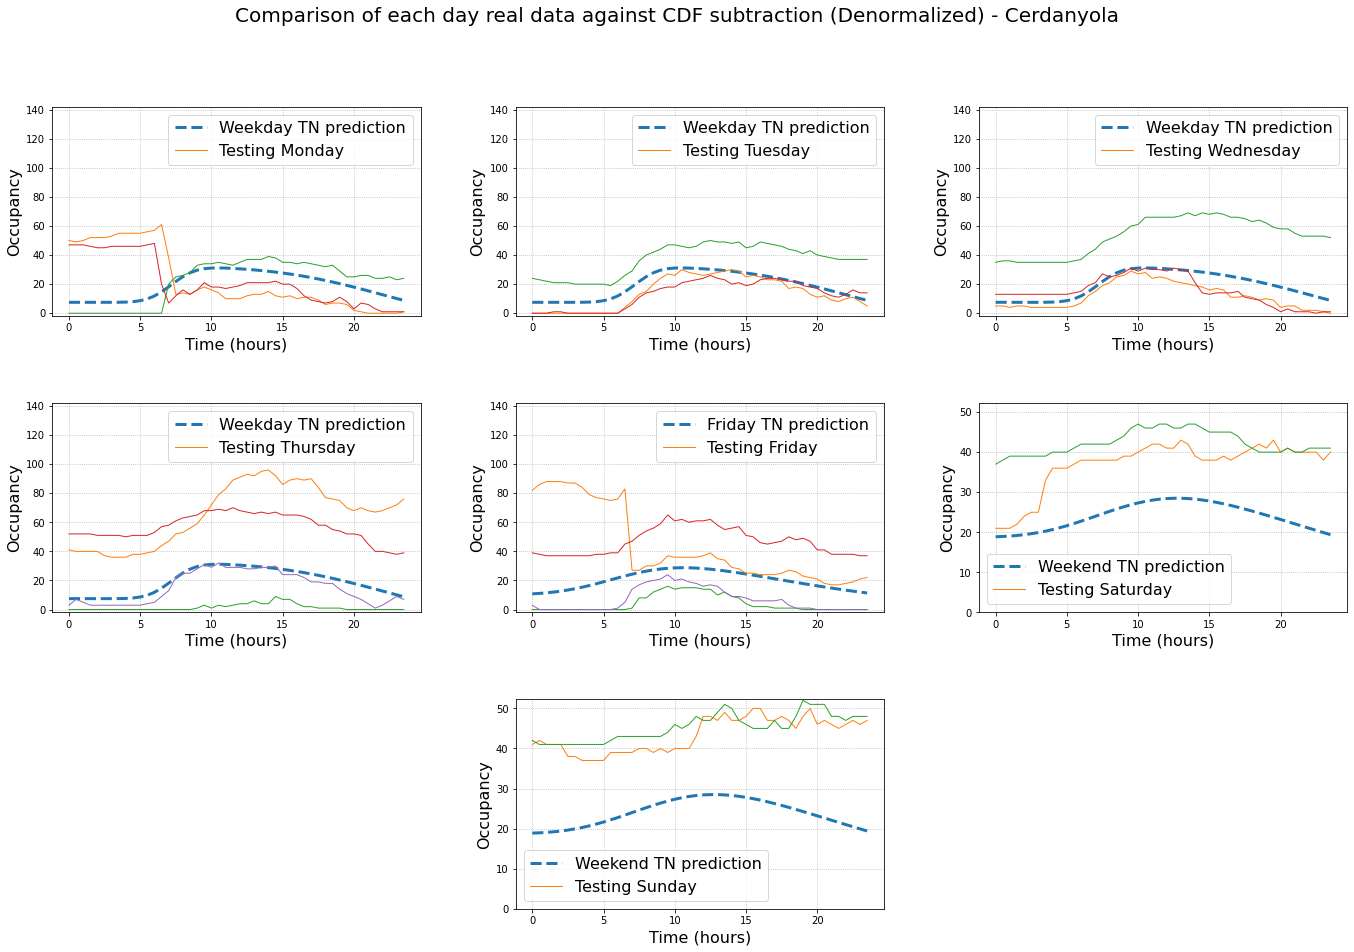

In [394]:
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(14)
fig.suptitle('Comparison of each day real data against CDF subtraction (Denormalized) - ' + current_parking, fontsize=20)

tn_weekday = tn_weekday_n*weekday_area + weekday_offset
tn_friday = tn_friday_n*friday_area + friday_offset
tn1_weekend = tn1_weekend_n*weekend_area + weekend_offset 

subplot_training(fig, ax, 0, 0, tn_weekday, testing_mondays, 'Monday', 'Weekday')
subplot_training(fig, ax, 0, 1, tn_weekday, testing_tuesdays, 'Tuesday', 'Weekday')
subplot_training(fig, ax, 0, 2, tn_weekday, testing_wednesdays, 'Wednesday', 'Weekday')
subplot_training(fig, ax, 1, 0, tn_weekday, testing_thursdays, 'Thursday', 'Weekday')
subplot_training(fig, ax, 1, 1, tn_friday, testing_fridays, 'Friday', 'Friday')
subplot_training(fig, ax, 1, 2, tn1_weekend, testing_saturdays, 'Saturday', 'Weekend')
subplot_training(fig, ax, 2, 1, tn1_weekend, testing_sundays, 'Sunday', 'Weekend')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
ax[2,1].set_ylim(0,axis_ylim_we)
ax[1,2].set_ylim(0,axis_ylim_we)
fig.tight_layout(pad=5.0)

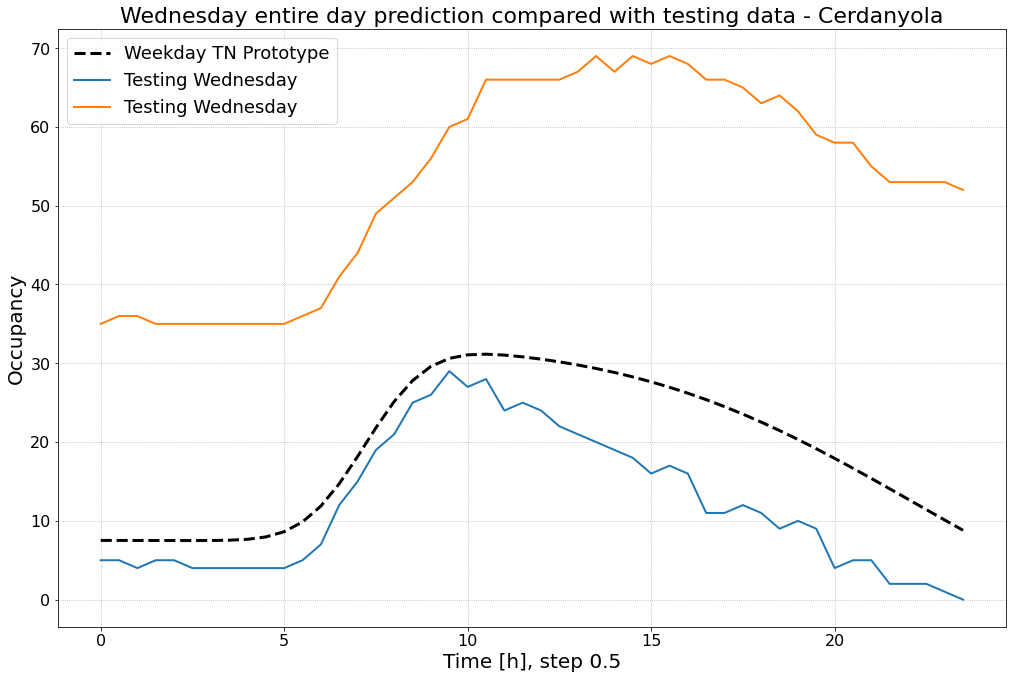

In [395]:
fig = plt.figure(figsize=(17,11))
plt.title('Wednesday entire day prediction compared with testing data - '+current_parking, fontsize = 22)
plt.plot(time, tn_weekday, linestyle='dashed', linewidth=3, color='black', label='Weekday TN Prototype')
plt.plot(time, testing_wednesdays[0], linewidth=2, label="Testing Wednesday")
plt.plot(time, testing_wednesdays[1], linewidth=2, label="Testing Wednesday")
# plt.plot(time, testing_wednesdays[3], linewidth=2, label="Testing Wednesday")
plt.grid(linestyle='dotted')
plt.legend(fontsize=18)
plt.xlabel('Time [h], step 0.5', fontsize=20)
plt.ylabel('Occupancy', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16);

______MEAN________
13.569783649117369
8.051511886914385
13.212282797519043
21.64707618144111
16.244023224043715
12.78811986736978
16.681562490320598
______STDV________
7.129739403298996
0.8530996305405963
3.883362669245108
3.2738071989906485
5.476007031067258
1.9243271284545664
2.9780598128263978


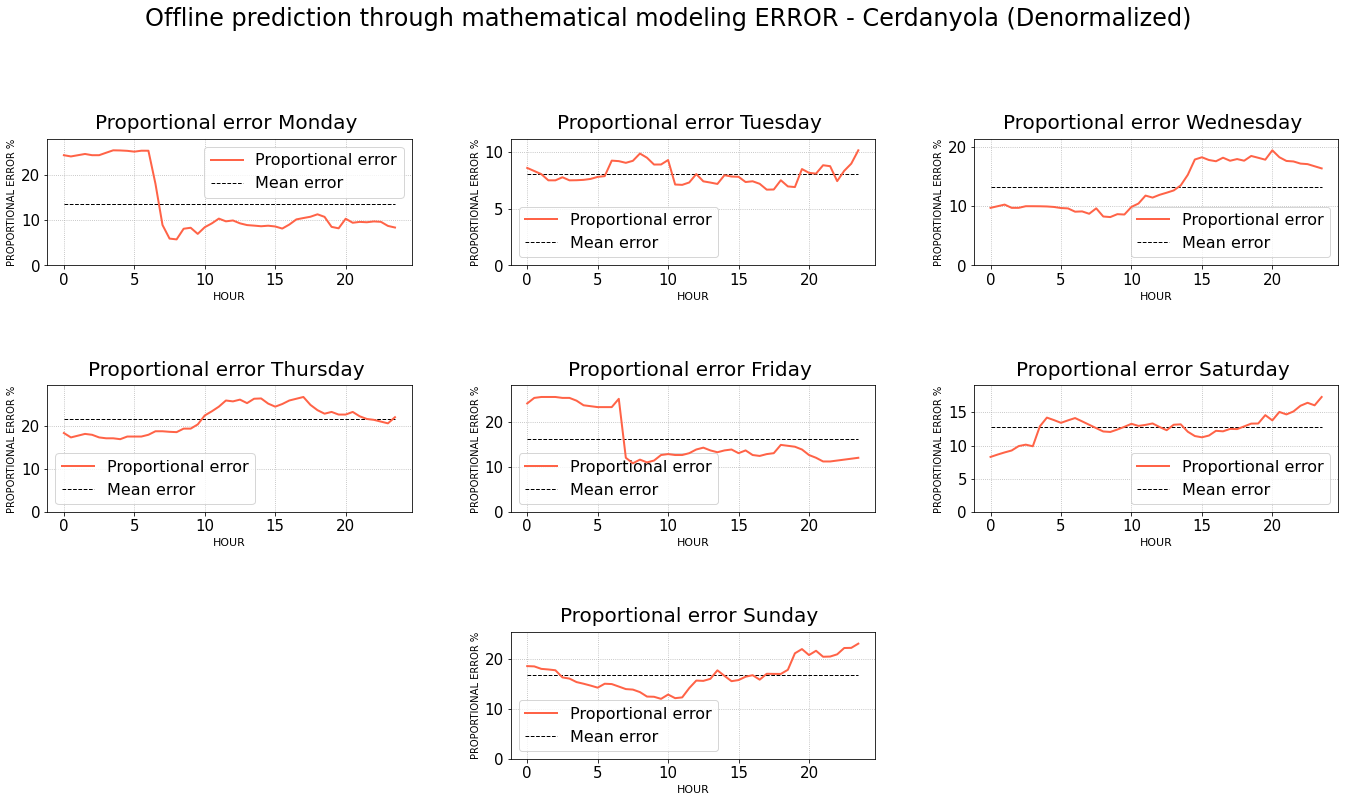

In [396]:
def compute_testing_prop_error(testing_days, proto_data):
    errors = np.zeros(48)
    n_test_days = len(testing_days)
    proto = np.array(proto_data)
    
    for i in range(0, n_test_days):
        day = np.array(testing_days[i])
        er = np.array((np.absolute(proto - day)/max_value)*100)
        errors += er
    return errors/n_test_days

error_monday_tn = compute_testing_prop_error(testing_mondays, tn_weekday)
error_tuesday_tn = compute_testing_prop_error(testing_tuesdays, tn_weekday)
error_wednesday_tn = compute_testing_prop_error(testing_wednesdays, tn_weekday)
error_thursday_tn = compute_testing_prop_error(testing_thursdays, tn_weekday)
error_friday_tn = compute_testing_prop_error(testing_fridays, tn_friday)
error_saturday_tn = compute_testing_prop_error(testing_saturdays, tn1_weekend)
error_sunday_tn = compute_testing_prop_error(testing_sundays, tn1_weekend)

def subplotCDFsubtractionErr(fig, ax, axx, axy, x, error, mean, title, day ):
    ax[axx,axy].plot(x, error, color="tomato", linewidth=2, zorder=10, label='Proportional error')
    ax[axx,axy].plot(x, mean, linewidth=1, linestyle='--' ,color='black', label='Mean error')
    ax[axx,axy].grid(linestyle='dotted')
    ax[axx,axy].set_ylabel('Proportional error %', fontsize=20)
    ax[axx,axy].set_xlabel('Hours', fontsize=20)
    ax[axx,axy].set_title(title , fontsize=20, pad=10)
    ax[axx,axy].set_ylim((0,1.1*max(error)))
    ax[axx,axy].legend(fontsize=16)
    ax[axx,axy].tick_params( labelsize=15)

    
fig, ax = plt.subplots(3, 3)
fig.set_figwidth(20)
fig.set_figheight(12)
fig.suptitle('Offline prediction through mathematical modeling ERROR - '+current_parking+' (Denormalized)', fontsize=24)
time = np.linspace(0,23.5,48)

mean_Monday =  [np.mean(error_monday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 0, time, error_monday_tn, mean_Monday, 
                 'Proportional error Monday ', 'Monday')

mean_Tuesday =  [np.mean(error_tuesday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 1, time, error_tuesday_tn, mean_Tuesday, 
                 'Proportional error Tuesday ', 'Tuesday')

mean_Wednesday =  [np.mean(error_wednesday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 0, 2, time, error_wednesday_tn, mean_Wednesday, 
                 'Proportional error Wednesday ', 'Wednesday')

mean_Thursday =  [np.mean(error_thursday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 0, time, error_thursday_tn, mean_Thursday, 
                 'Proportional error Thursday ', 'Thursday')

mean_Friday =  [np.mean(error_friday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 1, time, error_friday_tn, mean_Friday, 
                 'Proportional error Friday ', 'Friday')

mean_Saturday =  [np.mean(error_saturday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 1, 2, time, error_saturday_tn, mean_Saturday, 
                 'Proportional error Saturday ', 'Saturday')

mean_Sunday =  [np.mean(error_sunday_tn)]*len(time)
subplotCDFsubtractionErr(fig, ax, 2, 1, time, error_sunday_tn, mean_Sunday, 
                 'Proportional error Sunday ', 'Sunday')

ax[2,0].set_visible(False)
ax[2,2].set_visible(False)
fig.tight_layout(pad=5.0)
for ax in ax.flat:
    ax.set_ylabel('PROPORTIONAL ERROR %', fontsize=10)
    ax.set_xlabel('HOUR', fontsize=11)


print('______MEAN________')    

print(mean_Monday[0])
print(mean_Tuesday[0])
print(mean_Wednesday[0])
print(mean_Thursday[0])
print(mean_Friday[0])
print(mean_Saturday[0])
print(mean_Sunday[0])

print('______STDV________')

print(np.std(error_monday_tn))
print(np.std(error_tuesday_tn))
print(np.std(error_wednesday_tn))
print(np.std(error_thursday_tn))
print(np.std(error_friday_tn))
print(np.std(error_saturday_tn))
print(np.std(error_sunday_tn))


### MATHEMATICAL PROTOTYE: Real time prediction by SCALING

In [397]:
# Plotting methods to reduce cell dimension

def real_timing_predition(fig, ax, axx, day, tn_proto, real_day, scaled_proto, Prototype, limit_hour, t_date):
    fig.suptitle('Real time prediction Scaling mathematical and mean proto for Testing '
                 + day + ' ' +t_date + ' ('+ current_parking+')', fontsize='18')
    ax[axx].plot(time, real_day.values, linestyle='dashdot', linewidth=2, label='Real ' + day)
    ax[axx].plot(time, tn_proto,'--',color='grey', label='TN prototype (not scaled)')
    ax[axx].plot(time, scaled_proto, color='green', linewidth=2, label='TN proto (scaled)')
    ax[axx].plot(time, Prototype, color='orange', linewidth=2, label='Stat. scaled proto')
    ax[axx].axvline(x=limit_hour, linestyle='--', color='grey', linewidth=2, label='Moment of prediction')
    ax[axx].axvspan(0, limit_hour, facecolor='grey', alpha=0.2, label='Known Activity')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].legend(fontsize=9)
    ax[axx].set_ylim([0,1.1*max([max(real_day.values),max(tn_proto),max(scaled_proto),max(Prototype)])])
    ax[axx].set_xlabel('Hour', fontsize=14)
    ax[axx].set_ylabel('Occupancy', fontsize=14)

def errors_plotting(fig, ax, axx, scaled_proto, Prototype, real_day, day, limit_hour):
    #Computing Errors
    limit_hour = limit_hour*2
    tn_scaled_error = (np.absolute((np.array(scaled_proto) - np.array(real_day.values)))/max_value)*100
    mean_scaled_error = (np.absolute((np.array(Prototype) - np.array(real_day.values)))/max_value)*100

    tn_s_error_mean = [np.mean(tn_scaled_error[limit_hour:])]*len(tn_scaled_error)
    mean_s_error_mean = [np.mean(mean_scaled_error[limit_hour:])]*len(mean_scaled_error)

    #Second plot
#     time = time[limit_hour:]
    ax[axx].plot(time[limit_hour:], tn_scaled_error[limit_hour:], color='tomato', label='TN scaling error')
    ax[axx].plot(time[limit_hour:],tn_s_error_mean[limit_hour:], '--',color='tomato', label='TN Mean prop. error')
    ax[axx].plot(time[limit_hour:],mean_scaled_error[limit_hour:], color='blueviolet', label='Proto scaling error')
    ax[axx].plot(time[limit_hour:],mean_s_error_mean[limit_hour:], '--',color='blueviolet', label='Proto. Mean prop. error')
    ax[axx].grid(linestyle='dotted', linewidth='0.5', color='grey')
    ax[axx].axvline(x=limit_hour/2, linestyle='--', color='grey', linewidth=2, label='Moment of prediction')
    ax[axx].axvspan(0, limit_hour/2, facecolor='grey', alpha=0.2, label='Known Activity', zorder=4)
    ax[axx].legend(fontsize=12)
    ax[axx].set_ylim([0,1.1*max(max(tn_scaled_error[limit_hour:]),max(mean_scaled_error[limit_hour:]))])
    ax[axx].set_xlabel('Hour', fontsize=14)
    ax[axx].set_ylabel('Proportional error (%)', fontsize=14)

    print('Real ' + day + ' scaled prtotype error: ', round(100*mean_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled prtotype STDV: ', np.std(mean_scaled_error[limit_hour:]))

    print('Real ' + day + ' scaled TN error: ', round(100*tn_s_error_mean[0])/100, '%')
    print('Real ' + day + ' scaled TN STDV: ', np.std(tn_scaled_error[limit_hour:]))
    print('_____________________________________________________________')

def get_scaling_factor(limit_hour, test_day, proto):
    if limit_hour < 6:
        return 1
    index = limit_hour*2
    current_real_data = test_day.values[index]
    proto_value = proto[index]
    scaling = current_real_data/proto_value
    return scaling

#### MONDAY

2020-02-24
Real Monday scaled prtotype error:  2.37 %
Real Monday scaled prtotype STDV:  1.6322246542023162
Real Monday scaled TN error:  2.34 %
Real Monday scaled TN STDV:  1.6251592863245727
_____________________________________________________________
2020-03-02
Real Monday scaled prtotype error:  3.77 %
Real Monday scaled prtotype STDV:  2.0822017362906147
Real Monday scaled TN error:  3.86 %
Real Monday scaled TN STDV:  2.953399163968974
_____________________________________________________________
2020-03-09
Real Monday scaled prtotype error:  4.41 %
Real Monday scaled prtotype STDV:  1.8025298123035942
Real Monday scaled TN error:  4.37 %
Real Monday scaled TN STDV:  1.7471124604430501
_____________________________________________________________


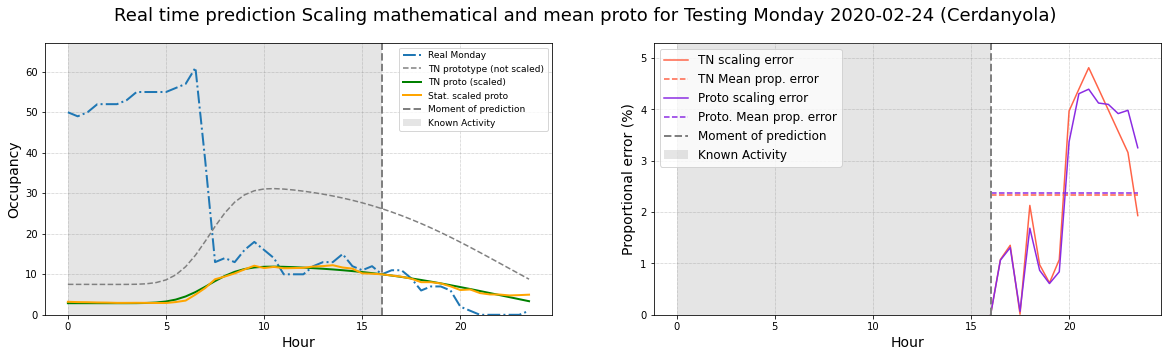

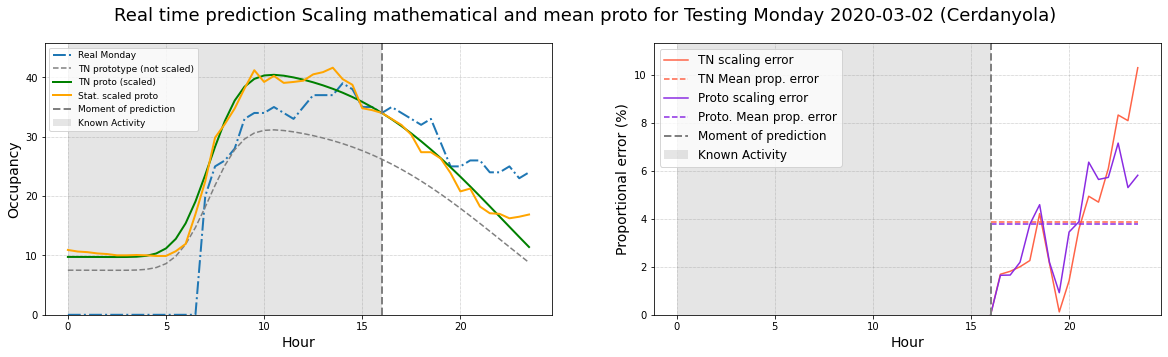

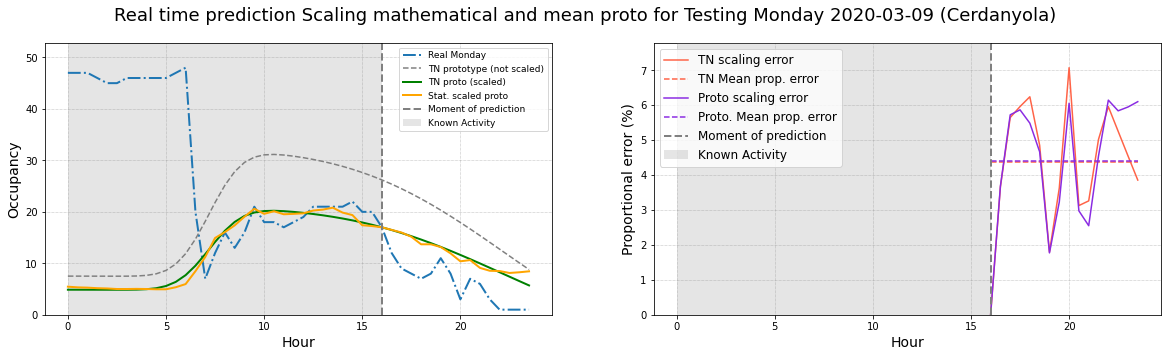

In [398]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_mondays
t_dates=testing_mondays_dates
limit_hour = 16
day = 'Monday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(5)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

#### TUESDAY

2020-02-25
Real Tuesday scaled prtotype error:  1.61 %
Real Tuesday scaled prtotype STDV:  1.1490402693727646
Real Tuesday scaled TN error:  1.95 %
Real Tuesday scaled TN STDV:  1.27668038017547
_____________________________________________________________
2020-03-03
Real Tuesday scaled prtotype error:  6.73 %
Real Tuesday scaled prtotype STDV:  5.154657926920378
Real Tuesday scaled TN error:  7.68 %
Real Tuesday scaled TN STDV:  5.271347023242945
_____________________________________________________________
2020-03-10
Real Tuesday scaled prtotype error:  4.64 %
Real Tuesday scaled prtotype STDV:  2.0592161027307254
Real Tuesday scaled TN error:  5.06 %
Real Tuesday scaled TN STDV:  2.117587096164786
_____________________________________________________________


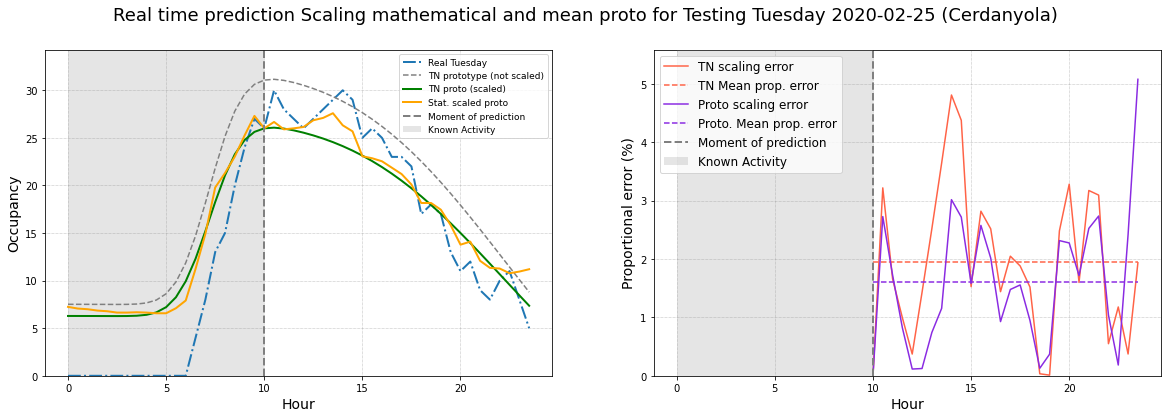

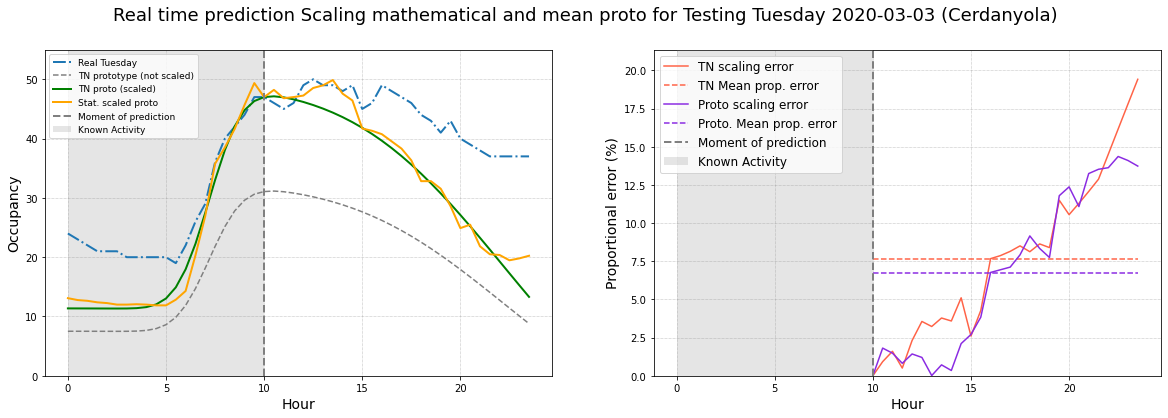

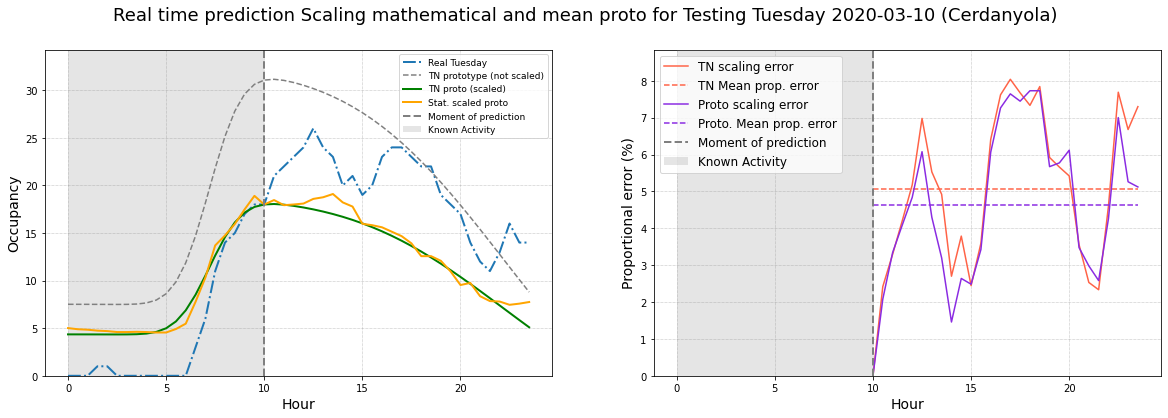

In [399]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_tuesdays
t_dates= testing_tuesdays_dates
limit_hour = 10
day = 'Tuesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

### WEDNESDAY

2020-02-26
Real Wednesday scaled prtotype error:  3.41 %
Real Wednesday scaled prtotype STDV:  1.9905059477781015
Real Wednesday scaled TN error:  3.88 %
Real Wednesday scaled TN STDV:  1.940185464905957
_____________________________________________________________
2020-03-04
Real Wednesday scaled prtotype error:  13.39 %
Real Wednesday scaled prtotype STDV:  6.86035671259522
Real Wednesday scaled TN error:  11.92 %
Real Wednesday scaled TN STDV:  7.273680728846829
_____________________________________________________________
2020-03-11
Real Wednesday scaled prtotype error:  8.7 %
Real Wednesday scaled prtotype STDV:  2.8498025908640874
Real Wednesday scaled TN error:  9.37 %
Real Wednesday scaled TN STDV:  3.4287639482421217
_____________________________________________________________


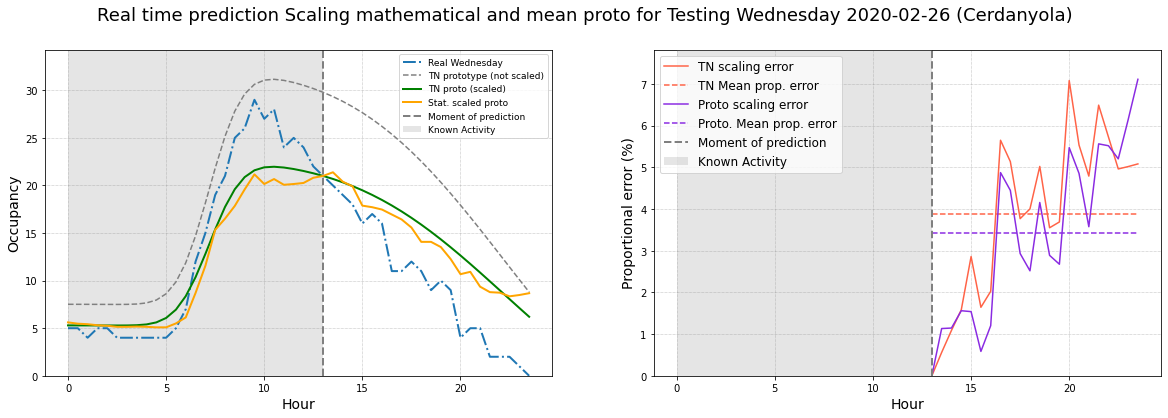

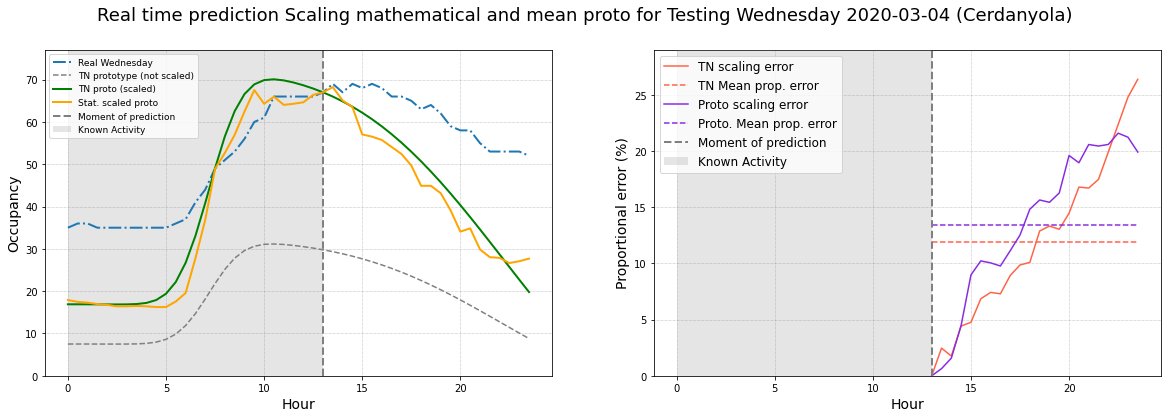

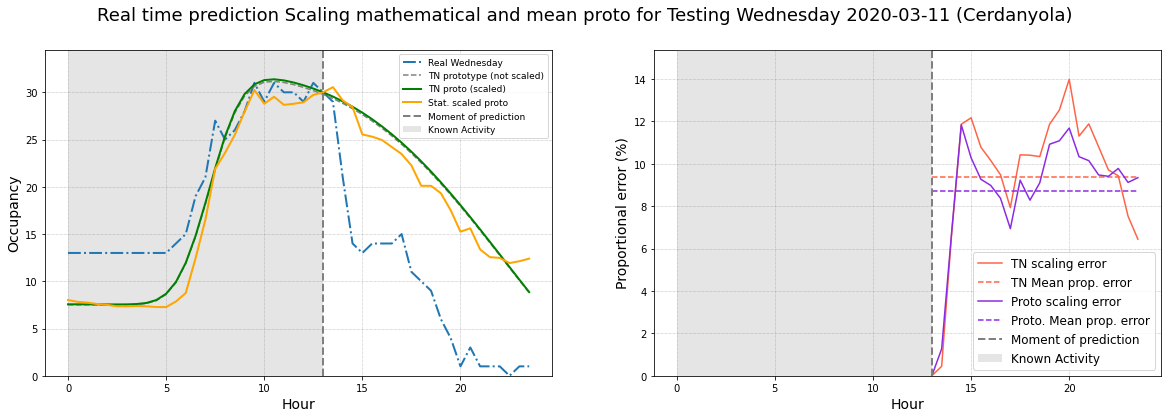

In [400]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_wednesdays
t_dates= testing_wednesdays_dates
limit_hour = 13
day = 'Wednesday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0

cont=0        
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

### THURSDAY

2020-02-20
Real Thursday scaled prtotype error:  14.54 %
Real Thursday scaled prtotype STDV:  8.551378177052753
Real Thursday scaled TN error:  12.52 %
Real Thursday scaled TN STDV:  10.315091974588778
_____________________________________________________________
2020-02-27
Real Thursday scaled prtotype error:  2.03 %
Real Thursday scaled prtotype STDV:  0.6527909442586967
Real Thursday scaled TN error:  2.1 %
Real Thursday scaled TN STDV:  0.7897149782572677
_____________________________________________________________
2020-03-05
Real Thursday scaled prtotype error:  8.41 %
Real Thursday scaled prtotype STDV:  3.886626070608143
Real Thursday scaled TN error:  6.94 %
Real Thursday scaled TN STDV:  3.825283370236518
_____________________________________________________________
2020-03-12
Real Thursday scaled prtotype error:  2.83 %
Real Thursday scaled prtotype STDV:  2.5412669790021503
Real Thursday scaled TN error:  3.42 %
Real Thursday scaled TN STDV:  2.8183267566005656
____________

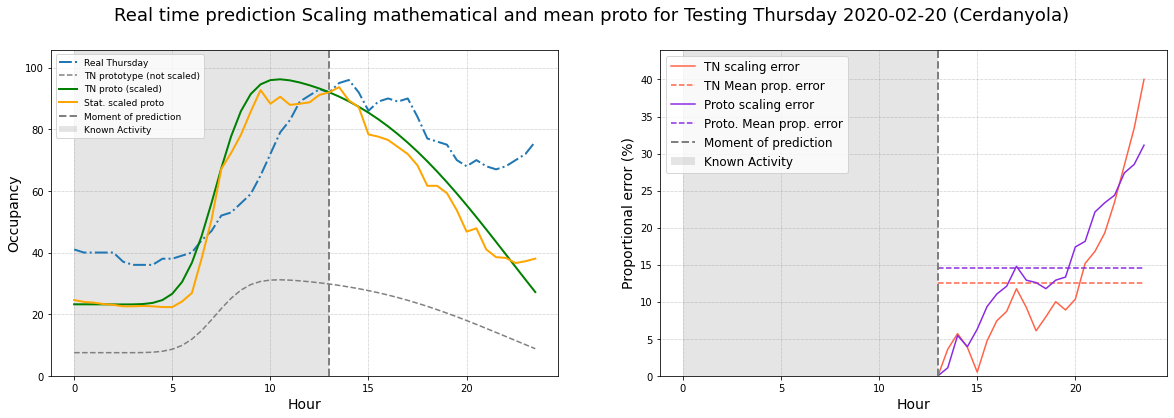

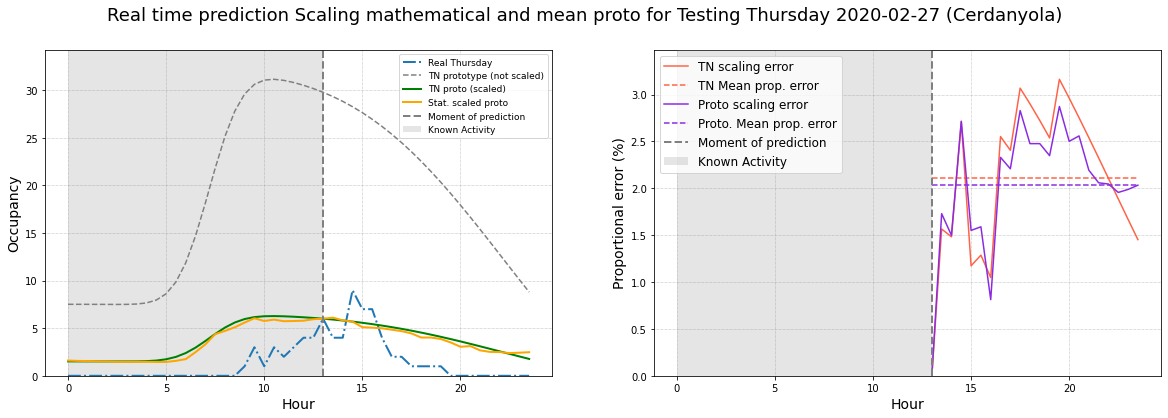

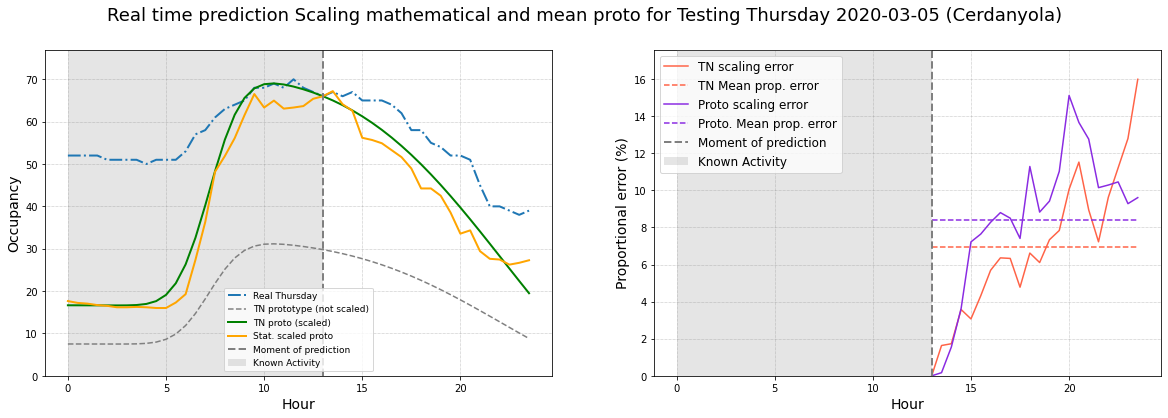

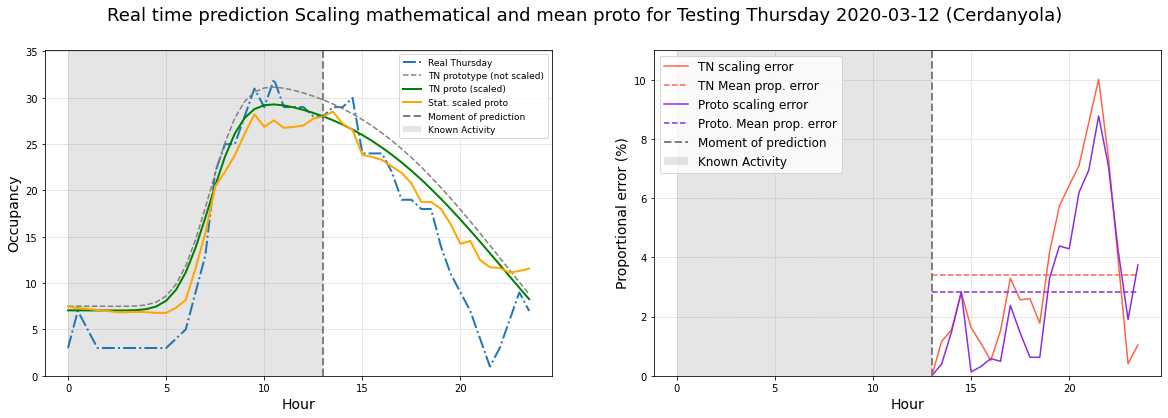

In [401]:
statistic_proto = hist_weekday_proto
tn_proto = tn_weekday
t_days = testing_thursdays
t_dates= testing_thursdays_dates
limit_hour = 13
day = 'Thursday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], hist_weekday_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = hist_weekday_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1
    

### FRIDAY

2020-02-21
Real Friday scaled prtotype error:  1.86 %
Real Friday scaled prtotype STDV:  1.6643675606907695
Real Friday scaled TN error:  3.31 %
Real Friday scaled TN STDV:  2.2061535394384397
_____________________________________________________________
2020-02-28
Real Friday scaled prtotype error:  0.94 %
Real Friday scaled prtotype STDV:  0.40053869394756414
Real Friday scaled TN error:  0.81 %
Real Friday scaled TN STDV:  0.3666903609717683
_____________________________________________________________
2020-03-06
Real Friday scaled prtotype error:  4.35 %
Real Friday scaled prtotype STDV:  2.9117194385540364
Real Friday scaled TN error:  7.32 %
Real Friday scaled TN STDV:  3.4513929499988394
_____________________________________________________________
2020-03-13
Real Friday scaled prtotype error:  2.56 %
Real Friday scaled prtotype STDV:  1.406630481914
Real Friday scaled TN error:  2.28 %
Real Friday scaled TN STDV:  1.1431801017698369
_____________________________________________

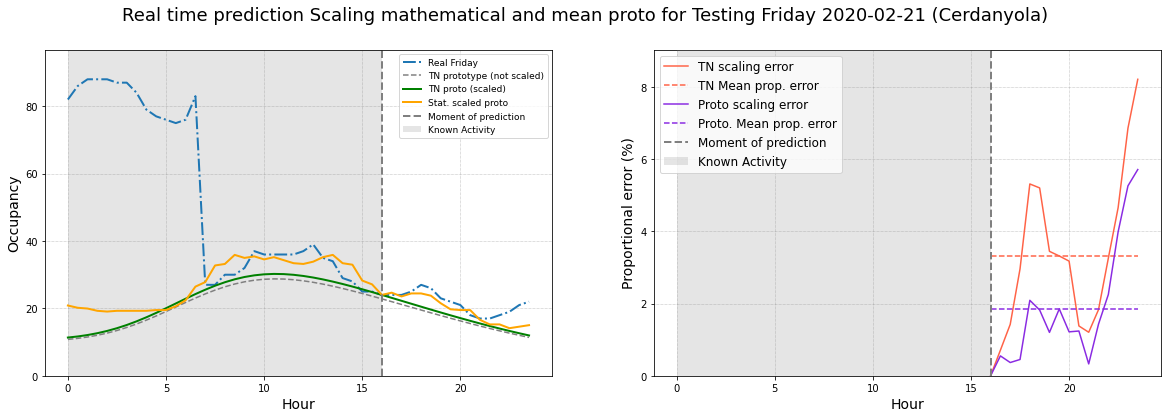

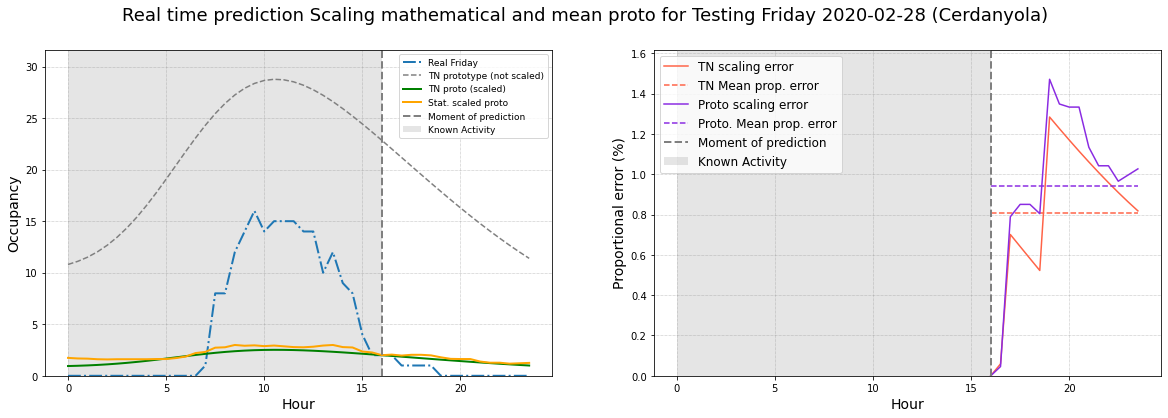

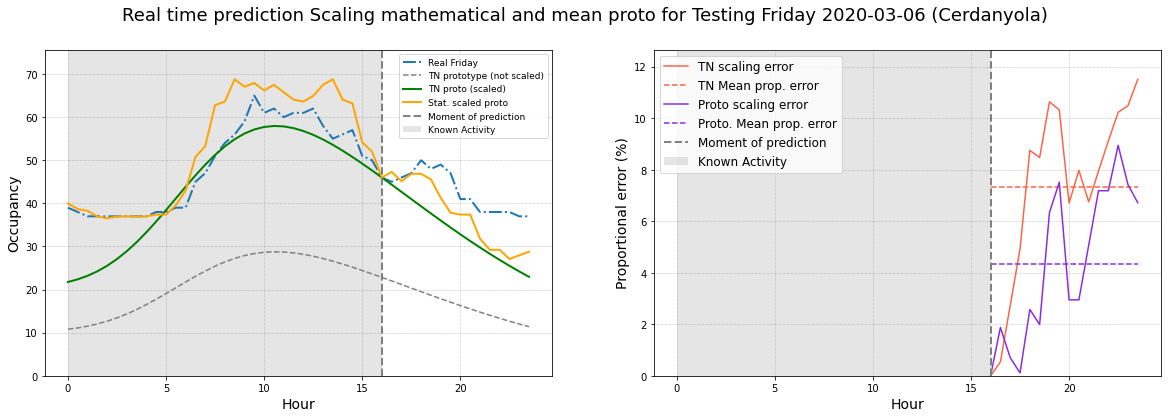

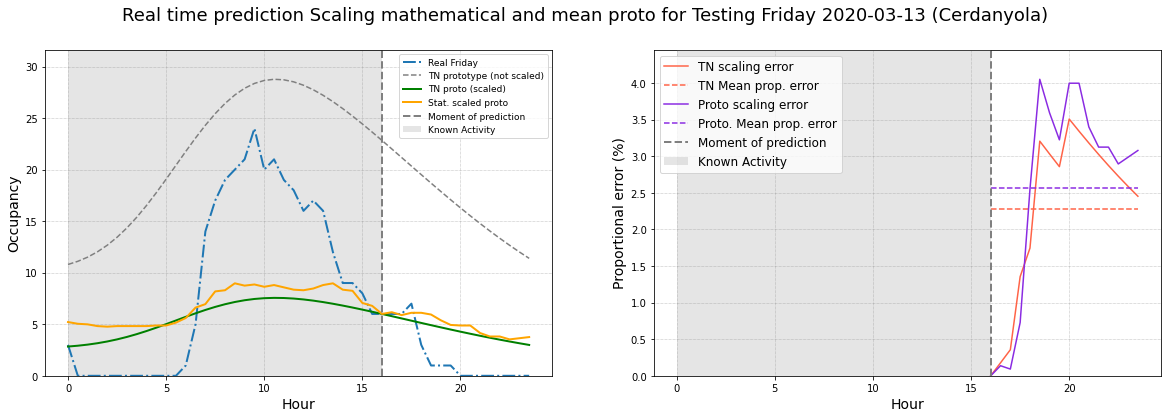

In [402]:
statistic_proto = hist_friday_proto
tn_proto = tn_friday
t_days = testing_fridays
t_dates=testing_fridays_dates
limit_hour = 16
day = 'Friday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
  
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1
    

### WEEKEND

### SATURDAY

2020-02-22
Real Saturday scaled prtotype error:  6.29 %
Real Saturday scaled prtotype STDV:  3.5161934855933334
Real Saturday scaled TN error:  5.34 %
Real Saturday scaled TN STDV:  2.956756702397858
_____________________________________________________________
2020-03-07
Real Saturday scaled prtotype error:  3.49 %
Real Saturday scaled prtotype STDV:  3.060439486086265
Real Saturday scaled TN error:  2.42 %
Real Saturday scaled TN STDV:  2.367874627926089
_____________________________________________________________


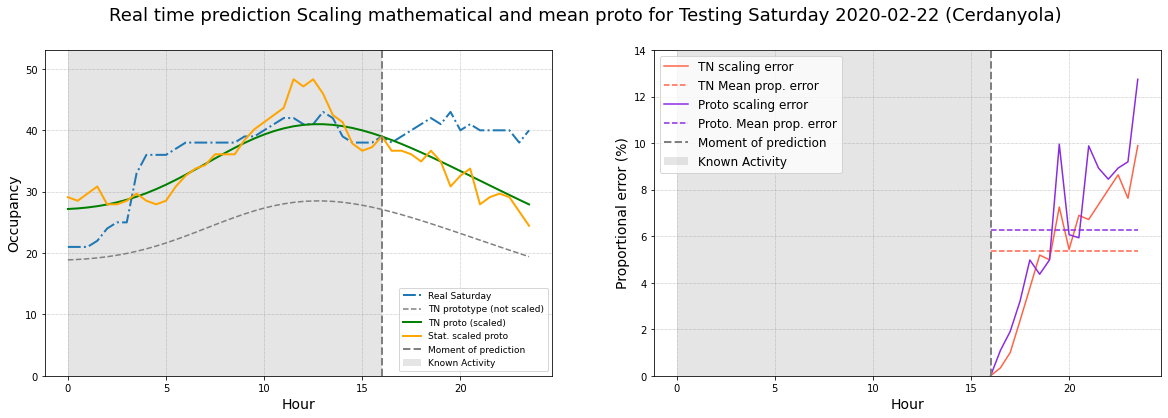

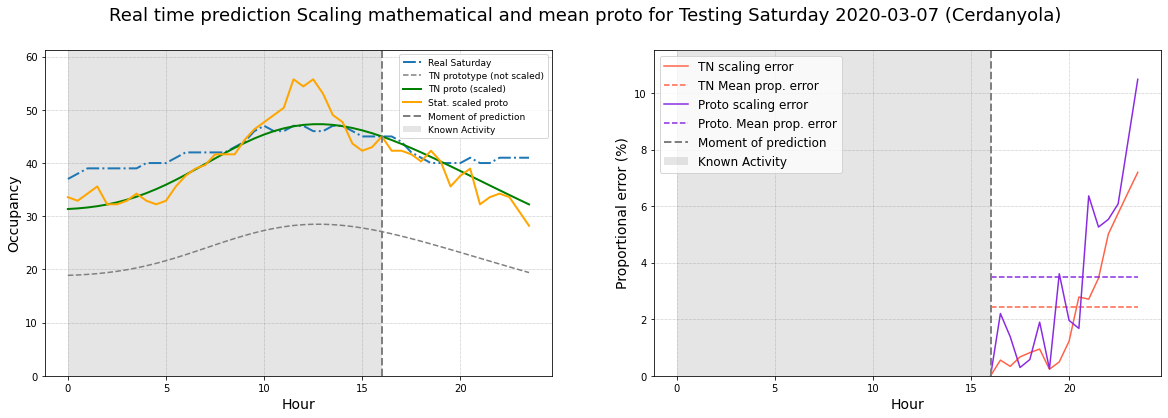

In [403]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_saturdays
t_dates= testing_saturdays_dates
limit_hour = 16
day = 'Saturday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
        
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

### SUNDAY

2020-02-23
Real Sunday scaled prtotype error:  9.78 %
Real Sunday scaled prtotype STDV:  4.1300483560339485
Real Sunday scaled TN error:  5.39 %
Real Sunday scaled TN STDV:  3.579891797266318
_____________________________________________________________
2020-03-08
Real Sunday scaled prtotype error:  9.1 %
Real Sunday scaled prtotype STDV:  4.980293780153025
Real Sunday scaled TN error:  5.11 %
Real Sunday scaled TN STDV:  4.205438008571405
_____________________________________________________________


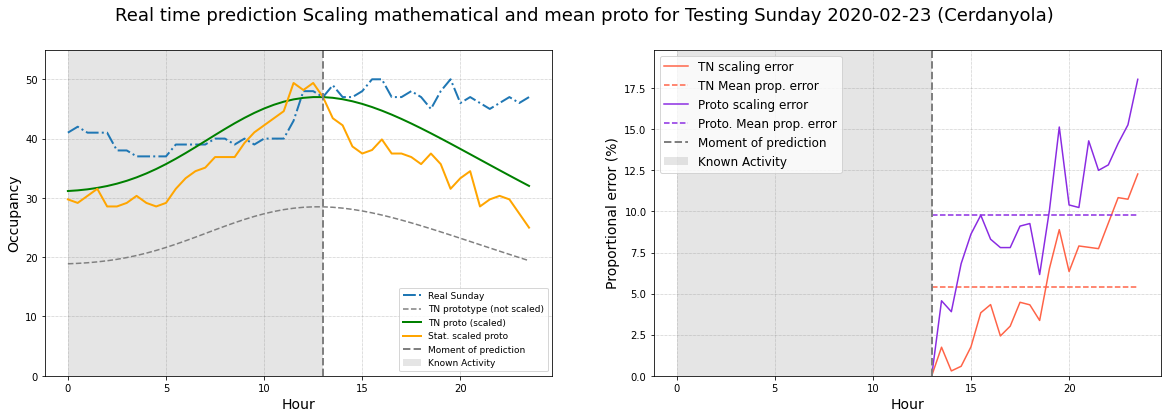

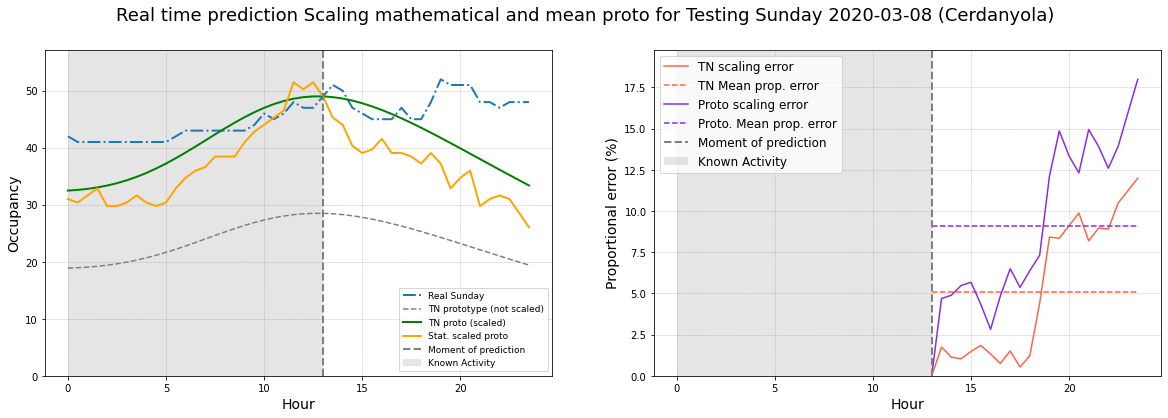

In [404]:
statistic_proto = hist_weekend_proto
tn_proto = tn1_weekend
t_days = testing_sundays
t_dates= testing_sundays_dates
limit_hour = 13
day = 'Sunday'
# Negative values to 0
for i in range(0,len(tn_proto)):
    if tn_proto[i] < 0:
        tn_proto[i] = 0
    
cont=0
for i in range(0,len(t_days)):
    t_date=t_dates[cont]
    print(t_date)
    tn_scaling = get_scaling_factor(limit_hour, t_days[i], tn_proto)
    stat_scaling = get_scaling_factor(limit_hour, t_days[i], statistic_proto.values)
    
    scaled_tn_proto = tn_proto * tn_scaling
    scaled_stat_proto = statistic_proto.values * stat_scaling
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(20)
    fig.set_figheight(6)
    axx=0;
    real_timing_predition(fig, ax, axx, day, tn_proto, t_days[i], scaled_tn_proto, scaled_stat_proto, limit_hour, t_date)
    #ax[0].set_ylim([0,axis_ylim_we])
    axx=1;
    errors_plotting(fig, ax, axx, scaled_tn_proto, scaled_stat_proto, t_days[i], day, limit_hour)
    cont=cont+1

# Store protos, params, areas and offsets

In [405]:
# df_prototypes = pd.read_csv('data/prototypes_new.csv')
# index = 0

# weekday_tn_params = ','.join(str(e) for e in list(res_weekday.x))
# friday_tn_params  = ','.join(str(e) for e in list(res_friday.x))
# weekend_tn_params = ','.join(str(e) for e in list(res_weekend.x))

# weekday_mean_area = weekday_area
# friday_mean_area  = friday_area
# weekend_mean_area = weekend_area

# weekday_mean_offset = weekday_offset
# friday_mean_offset  = friday_offset
# weekend_mean_offset = weekend_offset

# total_wave_weekday_s = ','.join(str(e) for e in tn_weekday.tolist())
# total_wave_weekend_s = ','.join(str(e) for e in tn1_weekend.tolist())
# total_wave_friday_s  = ','.join(str(e) for e in tn_friday.tolist())

# historical_weekday_s = ','.join(str(e) for e in hist_weekday_proto.tolist())
# historical_weekend_s = ','.join(str(e) for e in hist_weekend_proto.tolist())
# historical_friday_s  = ','.join(str(e) for e in hist_friday_proto.tolist())


# df_prototypes.at[index,'CDF subtraction_weekday_proto'] = total_wave_weekday_s
# df_prototypes.at[index,'CDF subtraction_friday_proto']  = total_wave_friday_s
# df_prototypes.at[index,'CDF subtraction_weekend_proto'] = total_wave_weekend_s

# df_prototypes.at[index,'CDF subtraction_weekday_params'] = weekday_tn_params
# df_prototypes.at[index,'CDF subtraction_friday_params']  = friday_tn_params
# df_prototypes.at[index,'CDF subtraction_weekend_params'] = weekend_tn_params

# df_prototypes.at[index,'CDF subtraction_weekday_area'] = weekday_mean_area
# df_prototypes.at[index,'CDF subtraction_friday_area']  = friday_mean_area
# df_prototypes.at[index,'CDF subtraction_weekend_area'] = weekend_mean_area

# df_prototypes.at[index,'CDF subtraction_weekday_offset'] = weekday_mean_offset
# df_prototypes.at[index,'CDF subtraction_friday_offset']  = friday_mean_offset
# df_prototypes.at[index,'CDF subtraction_weekend_offset'] = weekend_mean_offset

# df_prototypes.at[index,'Historical_weekday_proto'] = historical_weekday_s
# df_prototypes.at[index,'Historical_weekend_proto'] = historical_weekend_s
# df_prototypes.at[index,'Historical_friday_proto']  = historical_friday_s

# df_prototypes.to_csv("data/final_prototypes.csv", index=False)
# df_prototypes

In [406]:
# How to read the prorotypes: 
# string = exportable_df.at[0,'CDF subtraction_weekday_proto']
# list_of_strings = string.split(',')
# final_list = list(np.float_(list_of_strings))

In [407]:
# import pandas as pd
# df_prototypes_2 = pd.read_csv('data/prototypes_new.csv')
# new_row = {'Location':'Cerdanyola'}
# #append row to the dataframe
# df_prototypes_2 = df_prototypes_2.append(new_row, ignore_index=True)
# df_prototypes_2

In [408]:
# df_prototypes_2.to_csv("data/prototypes_new.csv", index=False)
# day = 'Monday'
# date = '2020-02-24'
# real_day = mean_of_day(day,date)
# real_day.values

In [409]:
# hist_friday_proto.tolist()